In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Experiment results for all 6 features (precip is removed)

In [6]:
# training = pd.read_csv('Data/ab_wind_train_data.txt')
# testing = pd.read_csv('Data/ab_wind_test_data.txt')
# All data without null, 2.5m
data = pd.read_csv('Data/processed_ab_wind_no_precip.csv')
#data = pd.read_csv('Data/processed_ab_wind.csv')

C:\Users\PPL\AppData\Local\Temp\ipykernel_46864\4035513363.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Data/processed_ab_wind_no_precip.csv')


In [7]:
data

longitude  latitude         name       id              date  temp  \
0          -112.82     53.05      CAMROSE  3011240  2010-01-01 00:00 -29.7   
1          -112.82     53.05      CAMROSE  3011240  2010-01-01 01:00 -28.7   
2          -112.82     53.05      CAMROSE  3011240  2010-01-01 02:00 -29.6   
3          -112.82     53.05      CAMROSE  3011240  2010-01-01 03:00 -28.9   
4          -112.82     53.05      CAMROSE  3011240  2010-01-01 04:00 -28.9   
...            ...       ...          ...      ...               ...   ...   
4899354    -110.28     54.42  COLD LAKE A  3081680  2023-09-14 19:00  12.6   
4899355    -110.28     54.42  COLD LAKE A  3081680  2023-09-14 20:00   9.9   
4899356    -110.28     54.42  COLD LAKE A  3081680  2023-09-14 21:00   9.7   
4899357    -110.28     54.42  COLD LAKE A  3081680  2023-09-14 22:00   8.8   
4899358    -110.28     54.42  COLD LAKE A  3081680  2023-09-14 23:00   6.9   

         wind_direction  wind_speed  
0                  13.0        13.0  
1                  14.0        19.0  
2                  14.0        15.0  
3                  14.0        20.0  
4                  14.0        20.0  
...                 ...         ...  
4899354            26.0         8.0  
4899355            23.0         5.0  
4899356            25.0         9.0  
4899357            24.0         5.0  
4899358            21.0         8.0  

[4899359 rows x 8 columns]

In [3]:
train_data = pd.read_csv('Data\processed_ab_no_precp_train.txt')
test_data = pd.read_csv('Data\processed_ab_no_precp_test.txt')

C:\Users\PPL\AppData\Local\Temp\ipykernel_96484\2297967146.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('Data\processed_ab_no_precp_train.txt')
C:\Users\PPL\AppData\Local\Temp\ipykernel_96484\2297967146.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('Data\processed_ab_no_precp_test.txt')


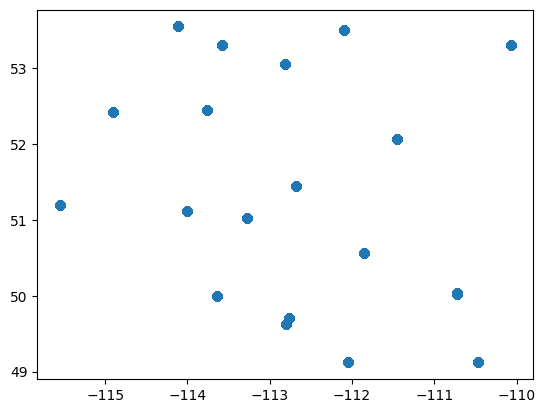

In [4]:
plt.scatter(x=train_data['longitude'], y=train_data['latitude'])
plt.show()

In [4]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [5]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()

    # Fcm hyperparameters
    FCM_Nc = 30
    FCM_m = 2
    #tol = 1e-10
    max_iter = 200
        
    N = train_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, train_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(train_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        qs.append(q)

        # 检查是否收敛
#         if np.linalg.norm(U - U_old) < tol:
#             break
    # 模型训练 find if this can be optimized
    z = np.hstack((np.ones((N, 1)), train_x))
    H = np.zeros((N, FCM_Nc * (train_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (train_x.shape[1] + 1, 1)).T
        H[:, (j * (train_x.shape[1] + 1)):((j + 1) * (train_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(train_y)

    time_used = time.time() - start_time
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(train_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(train_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    
    # validation
    N_validation = validation_x.shape[0]
    z_validation = np.hstack((np.ones((N_validation, 1)), validation_x))
    H_validation = np.zeros((N_validation, FCM_Nc * (validation_x.shape[1] + 1)))
    dists_validation = cdist(validation_x, cen)
    tmp_validation = np.power(dists_validation, -2 / (FCM_m - 1))
    U_validation = tmp_validation / np.sum(tmp_validation, axis=1, keepdims=True)

    # 生成模糊规则矩阵 H_test
    for j in range(FCM_Nc):
        Uj_validation = np.tile(U_validation[:, j], (validation_x.shape[1] + 1, 1)).T
        H_validation[:, (j * (validation_x.shape[1] + 1)):((j + 1) * (validation_x.shape[1] + 1))] = Uj_validation * z_validation

    # validation set
    y_hat_validation = np.dot(H_validation, W)
    mse_validation = mean_squared_error(validation_y, y_hat_validation)
    rmse_validation = sqrt(mse_validation)
    print("FCM val RMSE:", rmse_validation)
    

    # 模型测试
#     N_test = test_x.shape[0]
#     z_test = np.hstack((np.ones((N_test, 1)), test_x))
#     H_test = np.zeros((N_test, FCM_Nc * (test_x.shape[1] + 1)))
#     dists_test = cdist(test_x, cen)
#     tmp_test = np.power(dists_test, -2 / (FCM_m - 1))
#     U_test = tmp_test / np.sum(tmp_test, axis=1, keepdims=True)

#     # 生成模糊规则矩阵 H_test
#     for j in range(FCM_Nc):
#         Uj_test = np.tile(U_test[:, j], (test_x.shape[1] + 1, 1)).T
#         H_test[:, (j * (test_x.shape[1] + 1)):((j + 1) * (test_x.shape[1] + 1))] = Uj_test * z_test

#     # 在测试集上进行预测
#     y_hat_test = np.dot(H_test, W)
#     mse_test = mean_squared_error(test_y, y_hat_test)
#     rmse_test = sqrt(mean_squared_error(test_y, y_hat_test))
#     print("test MSE:", mse_test)
#     print("test RMSE:", rmse_test)
#     test_results.append({'fcm_test':rmse_test})
    
        
#     print('r2 score')
#     print(r2_score(test_y, y_hat_test))


    # 绘制拟合曲线
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.plot([min(train_y),max(train_y)], [min(train_y),max(train_y)], 'k--')
#     plt.plot(train_y, y_hat_train, 'ro', alpha=.2)
#     plt.title('Training')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
#     plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
#     plt.title('Testing')
#     plt.legend()
#     plt.show()
    # Plot the prediction vs the true value
    plt.figure(figsize=(8,8))    
    plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
    plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
    plt.title('TS model prediction vs true value for testing data')
    #plt.legend()
    plt.title('TS model optimization target Q v.s. iteration')
    plt.figure(figsize=(8,8))
    plt.plot(qs)
    #plt.show()

    return rmse_train, rmse_validation, time_used


In [6]:
def linear_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()

    reg = LinearRegression().fit(train_x, train_y)
    
    time_used = time.time() - start_time
        
    train_pred = reg.predict(train_x)
    
    validation_pred = reg.predict(validation_x)
    
    print("linear train")
    print(mean_squared_error(train_y, train_pred, squared = False))
    
    print("linear_validation")
    print(mean_squared_error(validation_y, validation_pred, squared = False))
    
    return mean_squared_error(train_y, train_pred, squared = False), mean_squared_error(validation_y, validation_pred, squared = False), time_used

In [7]:
def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1, activation=tf.keras.activations.relu))    
    
    return model

In [8]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()
    
    neural_network_model = build_neural_network_model()
    
    neural_network_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    history = neural_network_model.fit(
        train_x, 
        train_y, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    time_used = time.time() - start_time
    
    return history, np.mean(np.array(history.history['root_mean_squared_error'])), np.mean(np.array(history.history['val_root_mean_squared_error'])), neural_network_model, time_used

In [9]:
# Filter and process the data suitable for the training/testing
def generate_exp_data(raw_data, number_of_stations, max_threshold_distance, min_threshold_distance):
    # First fitler the data based on the settings
    x = []
    y = []

    for station in raw_data['name'].unique():
        features, target = Data_utils.generate_data(
            raw_data, 
            station, 
            number_of_stations, 
            max_threshold_distance, 
            min_threshold_distance
        )

        if (len(features)!=0) & (len(target)!=0):
            np_features = np.array(features)
            np_target = np.array(target)

            x.append(np_features)
            y.append(np_target)
    
    return x, y

In [46]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

# %store training_results
# %store training_times
# %store test_results
# %store nn_histories

#closing seesion, restarting kernel

# %store -r training_results
# %store -r training_times
# %store -r test_results
# %store -r nn_histories

Stored 'training_results' (list)
Stored 'training_times' (list)
Stored 'test_results' (list)
Stored 'nn_histories' (list)


In [25]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [11,12,13,14, 15,20] #[1,2,3,4,5,6,7,8,9, 10,11,12,13,14, 15,20]
number_of_epochs = 50

# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold
# General hyperparameter
max_threshold_distance = 100000 #km
min_threshold_distance = 0 #km

# Results containers
# training_results = []
# training_times = []
# test_results = []
# nn_histories = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values, train_data, test_data):
    kf = KFold(n_splits=number_of_folds, shuffle=True)
    
    for hyperparameter_value in hyper_parameter_to_test_values:
        
        if hyperparameter_value <= 11:
            # Station data is generated already, only need to train the model
            flatten_train_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x.csv", index_col=0).to_numpy()
            flatten_train_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y.csv", index_col=0).to_numpy()
            
            # Test data should still need to be generated
            test_x, test_y = generate_exp_data(test_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)
            flatten_test_x = np.array([data for sublist in test_x for data in sublist])
            flatten_test_y = np.array([data for sublist in test_y for data in sublist])
            
            temp_x = pd.DataFrame(flatten_test_x)
            temp_x.to_csv(f"Data\exp\{hyperparameter_value}x_test.csv")
            temp_y = pd.DataFrame(flatten_test_y)
            temp_y.to_csv(f"Data\exp\{hyperparameter_value}y_test.csv")
        else:
            # First fitler the data based on the settings
            train_x, train_y = generate_exp_data(train_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)
            test_x, test_y = generate_exp_data(test_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)

            # After all stations are filtered, flatten the data into a huge list        
            flatten_train_x = np.array([data for sublist in train_x for data in sublist])
            flatten_train_y = np.array([data for sublist in train_y for data in sublist])
            
            flatten_test_x = np.array([data for sublist in test_x for data in sublist])
            flatten_test_y = np.array([data for sublist in test_y for data in sublist])
        
            # Save those computed data
            temp_x = pd.DataFrame(flatten_train_x)
            temp_x.to_csv(f"Data\exp\{hyperparameter_value}x.csv")
            temp_y = pd.DataFrame(flatten_train_y)
            temp_y.to_csv(f"Data\exp\{hyperparameter_value}y.csv")
            
            temp_x = pd.DataFrame(flatten_test_x)
            temp_x.to_csv(f"Data\exp\{hyperparameter_value}x_test.csv")
            temp_y = pd.DataFrame(flatten_test_y)
            temp_y.to_csv(f"Data\exp\{hyperparameter_value}y_test.csv")
 
        
        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        training_times_fold = []
        test_results_fold = []
        nn_history_fold = []
        
        for i in range(1, 11):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")

            # Normalize the input
            flatten_train_x, flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)            
            # Linear model
            li_train_rmse, li_val_rmse, li_train_time = linear_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)
            training_results_fold.append({'linear_train' : li_train_rmse})
            training_times_fold.append({'linear_train' : li_train_time})
            test_results_fold.append({'linear_test' : li_val_rmse})
            
            # FCM model
            fcm_train_rmse, fcm_val_rmse,fcm_train_time = fcm_rule_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            training_times_fold.append({'fcm_train' : fcm_train_time})
            test_results_fold.append({'fcm_test' : fcm_val_rmse})
            
            # NN
            nn_history, nn_train_rmse, nn_val_rmse, nn_model, nn_train_time = neural_network_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)
            
            nn_test_prediction = nn_model.predict(flatten_test_x)
            # Plot the prediction vs the true value for neural network
            plt.figure(figsize=(8,8))    
            plt.plot([min(flatten_test_y),max(flatten_test_y)], [min(flatten_test_y),max(flatten_test_y)], 'k--')
            plt.plot(flatten_test_y, nn_test_prediction, 'ro', alpha=.2)
            plt.title('Neural network prediction vs true value for test data')
            # Record results
            nn_history_fold.append(nn_history.history)
            training_results_fold.append({'nn_train' : nn_train_rmse})
            training_times_fold.append({'nn_train' : nn_train_time})
            test_results_fold.append({'nn_test' : nn_val_rmse})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        training_times.append(training_times_fold)
        test_results.append(test_results_fold)
        nn_histories.append(nn_history_fold)        
        

Currently running fold 1 for 11 stations
linear train
6.540053904998194
linear_validation
6.55545242577149
FCM traning RMSE: 6.539987455253327
FCM val RMSE: 6.55543823051023
Epoch 1/50
16697/16697 [==============================] - 29s 2ms/step - loss: 46.4191 - root_mean_squared_error: 6.8132 - val_loss: 32.0519 - val_root_mean_squared_error: 5.6614
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 31.4239 - root_mean_squared_error: 5.6057 - val_loss: 31.0746 - val_root_mean_squared_error: 5.5745
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 30.8261 - root_mean_squared_error: 5.5521 - val_loss: 30.8078 - val_root_mean_squared_error: 5.5505
Epoch 4/50
16697/16697 [==============================] - 29s 2ms/step - loss: 30.5228 - root_mean_squared_error: 5.5247 - val_loss: 30.7156 - val_root_mean_squared_error: 5.5422
Epoch 5/50
16697/16697 [==============================] - 28s 2ms/step - loss: 30.3497 - root_mean_squared_err

16697/16697 [==============================] - 29s 2ms/step - loss: 29.1223 - root_mean_squared_error: 5.3965 - val_loss: 29.4222 - val_root_mean_squared_error: 5.4242
Epoch 46/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.1151 - root_mean_squared_error: 5.3958 - val_loss: 29.6509 - val_root_mean_squared_error: 5.4453
Epoch 47/50
16697/16697 [==============================] - 30s 2ms/step - loss: 29.0938 - root_mean_squared_error: 5.3939 - val_loss: 29.6673 - val_root_mean_squared_error: 5.4468
Epoch 48/50
16697/16697 [==============================] - 30s 2ms/step - loss: 29.1046 - root_mean_squared_error: 5.3949 - val_loss: 29.6273 - val_root_mean_squared_error: 5.4431
Epoch 49/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.0811 - root_mean_squared_error: 5.3927 - val_loss: 29.6540 - val_root_mean_squared_error: 5.4455
Epoch 50/50
7157/7157 [==============================] - 5s 631us/step
Currently running fold 2 for 11 stations


16697/16697 [==============================] - 28s 2ms/step - loss: 29.3134 - root_mean_squared_error: 5.4142 - val_loss: 29.6526 - val_root_mean_squared_error: 5.4454
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.3098 - root_mean_squared_error: 5.4138 - val_loss: 29.5285 - val_root_mean_squared_error: 5.4340
Epoch 41/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.2838 - root_mean_squared_error: 5.4114 - val_loss: 29.6136 - val_root_mean_squared_error: 5.4418
Epoch 42/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.2750 - root_mean_squared_error: 5.4106 - val_loss: 29.6585 - val_root_mean_squared_error: 5.4460
Epoch 43/50
16697/16697 [==============================] - 30s 2ms/step - loss: 29.2562 - root_mean_squared_error: 5.4089 - val_loss: 29.8013 - val_root_mean_squared_error: 5.4591
Epoch 44/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.2579 - root_mean_squared_erro

16697/16697 [==============================] - 27s 2ms/step - loss: 29.2068 - root_mean_squared_error: 5.4043 - val_loss: 29.6067 - val_root_mean_squared_error: 5.4412
Epoch 34/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1777 - root_mean_squared_error: 5.4016 - val_loss: 29.6685 - val_root_mean_squared_error: 5.4469
Epoch 35/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.1641 - root_mean_squared_error: 5.4004 - val_loss: 29.6241 - val_root_mean_squared_error: 5.4428
Epoch 36/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1579 - root_mean_squared_error: 5.3998 - val_loss: 29.4922 - val_root_mean_squared_error: 5.4307
Epoch 37/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.1327 - root_mean_squared_error: 5.3975 - val_loss: 29.4899 - val_root_mean_squared_error: 5.4305
Epoch 38/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1093 - root_mean_squared_erro

16697/16697 [==============================] - 29s 2ms/step - loss: 29.2983 - root_mean_squared_error: 5.4128 - val_loss: 29.5710 - val_root_mean_squared_error: 5.4379
Epoch 28/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.2701 - root_mean_squared_error: 5.4102 - val_loss: 29.8184 - val_root_mean_squared_error: 5.4606
Epoch 29/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.2678 - root_mean_squared_error: 5.4100 - val_loss: 29.5478 - val_root_mean_squared_error: 5.4358
Epoch 30/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.2404 - root_mean_squared_error: 5.4074 - val_loss: 29.5038 - val_root_mean_squared_error: 5.4317
Epoch 31/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.2156 - root_mean_squared_error: 5.4051 - val_loss: 29.6932 - val_root_mean_squared_error: 5.4491
Epoch 32/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.2146 - root_mean_squared_erro

16697/16697 [==============================] - 28s 2ms/step - loss: 29.5065 - root_mean_squared_error: 5.4320 - val_loss: 30.0120 - val_root_mean_squared_error: 5.4783
Epoch 22/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.5108 - root_mean_squared_error: 5.4324 - val_loss: 29.9400 - val_root_mean_squared_error: 5.4717
Epoch 23/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.4740 - root_mean_squared_error: 5.4290 - val_loss: 29.7296 - val_root_mean_squared_error: 5.4525
Epoch 24/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.4864 - root_mean_squared_error: 5.4301 - val_loss: 29.7752 - val_root_mean_squared_error: 5.4567
Epoch 25/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.4548 - root_mean_squared_error: 5.4272 - val_loss: 30.0515 - val_root_mean_squared_error: 5.4819
Epoch 26/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.4281 - root_mean_squared_erro

16697/16697 [==============================] - 28s 2ms/step - loss: 29.5363 - root_mean_squared_error: 5.4347 - val_loss: 29.9439 - val_root_mean_squared_error: 5.4721
Epoch 16/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.5119 - root_mean_squared_error: 5.4325 - val_loss: 29.6127 - val_root_mean_squared_error: 5.4418
Epoch 17/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.4725 - root_mean_squared_error: 5.4289 - val_loss: 29.8323 - val_root_mean_squared_error: 5.4619
Epoch 18/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.4623 - root_mean_squared_error: 5.4279 - val_loss: 29.5263 - val_root_mean_squared_error: 5.4338
Epoch 19/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.4260 - root_mean_squared_error: 5.4246 - val_loss: 30.0867 - val_root_mean_squared_error: 5.4851
Epoch 20/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.4153 - root_mean_squared_erro

16697/16697 [==============================] - 28s 2ms/step - loss: 29.9147 - root_mean_squared_error: 5.4694 - val_loss: 30.0442 - val_root_mean_squared_error: 5.4813
Epoch 10/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.8517 - root_mean_squared_error: 5.4637 - val_loss: 30.0288 - val_root_mean_squared_error: 5.4799
Epoch 11/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.8020 - root_mean_squared_error: 5.4591 - val_loss: 29.8445 - val_root_mean_squared_error: 5.4630
Epoch 12/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.7329 - root_mean_squared_error: 5.4528 - val_loss: 30.0456 - val_root_mean_squared_error: 5.4814
Epoch 13/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.6822 - root_mean_squared_error: 5.4481 - val_loss: 29.8907 - val_root_mean_squared_error: 5.4672
Epoch 14/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.6581 - root_mean_squared_erro

C:\Users\PPL\AppData\Local\Temp\ipykernel_96484\2390612765.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


Currently running fold 8 for 11 stations
linear train
6.54009408412878
linear_validation
6.555686595157861
FCM traning RMSE: 6.539987468262963
FCM val RMSE: 6.555433681019897
Epoch 1/50
16697/16697 [==============================] - 28s 2ms/step - loss: 41.0215 - root_mean_squared_error: 6.4048 - val_loss: 31.9867 - val_root_mean_squared_error: 5.6557
Epoch 2/50
16697/16697 [==============================] - 27s 2ms/step - loss: 31.2682 - root_mean_squared_error: 5.5918 - val_loss: 31.1889 - val_root_mean_squared_error: 5.5847
Epoch 3/50
16697/16697 [==============================] - 28s 2ms/step - loss: 30.6944 - root_mean_squared_error: 5.5403 - val_loss: 30.4995 - val_root_mean_squared_error: 5.5226
Epoch 4/50
16697/16697 [==============================] - 27s 2ms/step - loss: 30.4264 - root_mean_squared_error: 5.5160 - val_loss: 30.5495 - val_root_mean_squared_error: 5.5272
Epoch 5/50
16697/16697 [==============================] - 28s 2ms/step - loss: 30.2326 - root_mean_squared_er

16697/16697 [==============================] - 28s 2ms/step - loss: 29.2448 - root_mean_squared_error: 5.4078 - val_loss: 29.6109 - val_root_mean_squared_error: 5.4416
Epoch 46/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.2356 - root_mean_squared_error: 5.4070 - val_loss: 29.4895 - val_root_mean_squared_error: 5.4304
Epoch 47/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.2425 - root_mean_squared_error: 5.4076 - val_loss: 29.6025 - val_root_mean_squared_error: 5.4408
Epoch 48/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.2194 - root_mean_squared_error: 5.4055 - val_loss: 29.5071 - val_root_mean_squared_error: 5.4320
Epoch 49/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.2091 - root_mean_squared_error: 5.4045 - val_loss: 29.4810 - val_root_mean_squared_error: 5.4296
Epoch 50/50
7157/7157 [==============================] - 4s 521us/step
Currently running fold 9 for 11 stations


16697/16697 [==============================] - 27s 2ms/step - loss: 29.1367 - root_mean_squared_error: 5.3978 - val_loss: 29.5437 - val_root_mean_squared_error: 5.4354
Epoch 40/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1345 - root_mean_squared_error: 5.3976 - val_loss: 29.5681 - val_root_mean_squared_error: 5.4377
Epoch 41/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1100 - root_mean_squared_error: 5.3954 - val_loss: 29.3946 - val_root_mean_squared_error: 5.4217
Epoch 42/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.1205 - root_mean_squared_error: 5.3963 - val_loss: 29.4500 - val_root_mean_squared_error: 5.4268
Epoch 43/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.1093 - root_mean_squared_error: 5.3953 - val_loss: 29.2294 - val_root_mean_squared_error: 5.4064
Epoch 44/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.0799 - root_mean_squared_erro

16697/16697 [==============================] - 29s 2ms/step - loss: 29.1059 - root_mean_squared_error: 5.3950 - val_loss: 29.2970 - val_root_mean_squared_error: 5.4127
Epoch 34/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.0933 - root_mean_squared_error: 5.3938 - val_loss: 29.5311 - val_root_mean_squared_error: 5.4343
Epoch 35/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.0691 - root_mean_squared_error: 5.3916 - val_loss: 29.4935 - val_root_mean_squared_error: 5.4308
Epoch 36/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.0524 - root_mean_squared_error: 5.3900 - val_loss: 29.2502 - val_root_mean_squared_error: 5.4083
Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.0361 - root_mean_squared_error: 5.3885 - val_loss: 29.3304 - val_root_mean_squared_error: 5.4158
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.0274 - root_mean_squared_erro

16697/16697 [==============================] - 29s 2ms/step - loss: 29.4643 - root_mean_squared_error: 5.4281 - val_loss: 29.6849 - val_root_mean_squared_error: 5.4484
Epoch 28/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.4472 - root_mean_squared_error: 5.4265 - val_loss: 29.9485 - val_root_mean_squared_error: 5.4725
Epoch 29/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.4287 - root_mean_squared_error: 5.4248 - val_loss: 29.6964 - val_root_mean_squared_error: 5.4494
Epoch 30/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.4142 - root_mean_squared_error: 5.4235 - val_loss: 29.6589 - val_root_mean_squared_error: 5.4460
Epoch 31/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.4082 - root_mean_squared_error: 5.4229 - val_loss: 29.7943 - val_root_mean_squared_error: 5.4584
Epoch 32/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.3982 - root_mean_squared_erro

16697/16697 [==============================] - 27s 2ms/step - loss: 29.6643 - root_mean_squared_error: 5.4465 - val_loss: 29.8989 - val_root_mean_squared_error: 5.4680
Epoch 22/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.6491 - root_mean_squared_error: 5.4451 - val_loss: 29.9331 - val_root_mean_squared_error: 5.4711
Epoch 23/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.6410 - root_mean_squared_error: 5.4444 - val_loss: 29.8399 - val_root_mean_squared_error: 5.4626
Epoch 24/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.6128 - root_mean_squared_error: 5.4418 - val_loss: 29.7662 - val_root_mean_squared_error: 5.4558
Epoch 25/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.6026 - root_mean_squared_error: 5.4408 - val_loss: 29.9534 - val_root_mean_squared_error: 5.4730
Epoch 26/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.5758 - root_mean_squared_erro

16697/16697 [==============================] - 27s 2ms/step - loss: 29.8022 - root_mean_squared_error: 5.4591 - val_loss: 30.2112 - val_root_mean_squared_error: 5.4965
Epoch 16/50
16697/16697 [==============================] - 26s 2ms/step - loss: 29.7731 - root_mean_squared_error: 5.4565 - val_loss: 29.9951 - val_root_mean_squared_error: 5.4768
Epoch 17/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.7548 - root_mean_squared_error: 5.4548 - val_loss: 29.9226 - val_root_mean_squared_error: 5.4702
Epoch 18/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.7362 - root_mean_squared_error: 5.4531 - val_loss: 29.9918 - val_root_mean_squared_error: 5.4765
Epoch 19/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.7112 - root_mean_squared_error: 5.4508 - val_loss: 29.9034 - val_root_mean_squared_error: 5.4684
Epoch 20/50
16697/16697 [==============================] - 26s 2ms/step - loss: 29.6863 - root_mean_squared_erro

16697/16697 [==============================] - 29s 2ms/step - loss: 29.8978 - root_mean_squared_error: 5.4679 - val_loss: 30.0602 - val_root_mean_squared_error: 5.4827
Epoch 10/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.8173 - root_mean_squared_error: 5.4605 - val_loss: 30.1639 - val_root_mean_squared_error: 5.4922
Epoch 11/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.7903 - root_mean_squared_error: 5.4580 - val_loss: 30.2283 - val_root_mean_squared_error: 5.4980
Epoch 12/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.7521 - root_mean_squared_error: 5.4546 - val_loss: 29.9586 - val_root_mean_squared_error: 5.4734
Epoch 13/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.7185 - root_mean_squared_error: 5.4515 - val_loss: 29.9329 - val_root_mean_squared_error: 5.4711
Epoch 14/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.6967 - root_mean_squared_erro

16697/16697 [==============================] - 28s 2ms/step - loss: 30.6835 - root_mean_squared_error: 5.5393 - val_loss: 30.6571 - val_root_mean_squared_error: 5.5369
Epoch 4/50
16697/16697 [==============================] - 28s 2ms/step - loss: 30.4119 - root_mean_squared_error: 5.5147 - val_loss: 30.4186 - val_root_mean_squared_error: 5.5153
Epoch 5/50
16697/16697 [==============================] - 28s 2ms/step - loss: 30.2326 - root_mean_squared_error: 5.4984 - val_loss: 30.5575 - val_root_mean_squared_error: 5.5279
Epoch 6/50
16697/16697 [==============================] - 29s 2ms/step - loss: 30.0952 - root_mean_squared_error: 5.4859 - val_loss: 30.2771 - val_root_mean_squared_error: 5.5025
Epoch 7/50
16697/16697 [==============================] - 29s 2ms/step - loss: 30.0103 - root_mean_squared_error: 5.4782 - val_loss: 30.0076 - val_root_mean_squared_error: 5.4779
Epoch 8/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.9239 - root_mean_squared_error: 5.

16697/16697 [==============================] - 28s 2ms/step - loss: 29.0131 - root_mean_squared_error: 5.3864 - val_loss: 29.3051 - val_root_mean_squared_error: 5.4134
Epoch 49/50
16697/16697 [==============================] - 28s 2ms/step - loss: 28.9938 - root_mean_squared_error: 5.3846 - val_loss: 29.3344 - val_root_mean_squared_error: 5.4161
Epoch 50/50
7157/7157 [==============================] - 4s 511us/step
Currently running fold 6 for 12 stations
linear train
6.571570545609528
linear_validation
6.584020315160889
FCM traning RMSE: 6.571482909613047
FCM val RMSE: 6.583815260827632
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 41.7779 - root_mean_squared_error: 6.4636 - val_loss: 31.7710 - val_root_mean_squared_error: 5.6366
Epoch 2/50
16697/16697 [==============================] - 28s 2ms/step - loss: 31.1807 - root_mean_squared_error: 5.5840 - val_loss: 31.0232 - val_root_mean_squared_error: 5.5698
Epoch 3/50
16697/16697 [=======================

16697/16697 [==============================] - 27s 2ms/step - loss: 29.1954 - root_mean_squared_error: 5.4033 - val_loss: 29.4264 - val_root_mean_squared_error: 5.4246
Epoch 43/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1791 - root_mean_squared_error: 5.4018 - val_loss: 29.4158 - val_root_mean_squared_error: 5.4236
Epoch 44/50
16697/16697 [==============================] - 26s 2ms/step - loss: 29.1642 - root_mean_squared_error: 5.4004 - val_loss: 29.5422 - val_root_mean_squared_error: 5.4353
Epoch 45/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1451 - root_mean_squared_error: 5.3986 - val_loss: 29.3372 - val_root_mean_squared_error: 5.4164
Epoch 46/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.1367 - root_mean_squared_error: 5.3978 - val_loss: 29.5486 - val_root_mean_squared_error: 5.4359
Epoch 47/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.1284 - root_mean_squared_erro

16697/16697 [==============================] - 26s 2ms/step - loss: 29.1786 - root_mean_squared_error: 5.4017 - val_loss: 29.5797 - val_root_mean_squared_error: 5.4387
Epoch 37/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1896 - root_mean_squared_error: 5.4027 - val_loss: 29.4160 - val_root_mean_squared_error: 5.4237
Epoch 38/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1672 - root_mean_squared_error: 5.4007 - val_loss: 29.3724 - val_root_mean_squared_error: 5.4196
Epoch 39/50
16697/16697 [==============================] - 26s 2ms/step - loss: 29.1461 - root_mean_squared_error: 5.3987 - val_loss: 29.3792 - val_root_mean_squared_error: 5.4203
Epoch 40/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1418 - root_mean_squared_error: 5.3983 - val_loss: 29.4543 - val_root_mean_squared_error: 5.4272
Epoch 41/50
16697/16697 [==============================] - 27s 2ms/step - loss: 29.1176 - root_mean_squared_erro

16697/16697 [==============================] - 29s 2ms/step - loss: 29.3668 - root_mean_squared_error: 5.4191 - val_loss: 29.7696 - val_root_mean_squared_error: 5.4562
Epoch 31/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.3457 - root_mean_squared_error: 5.4172 - val_loss: 29.4428 - val_root_mean_squared_error: 5.4261
Epoch 32/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.3088 - root_mean_squared_error: 5.4138 - val_loss: 29.7825 - val_root_mean_squared_error: 5.4573
Epoch 33/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.3060 - root_mean_squared_error: 5.4135 - val_loss: 29.5553 - val_root_mean_squared_error: 5.4365
Epoch 34/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.2794 - root_mean_squared_error: 5.4110 - val_loss: 29.4747 - val_root_mean_squared_error: 5.4291
Epoch 35/50
16697/16697 [==============================] - 29s 2ms/step - loss: 29.2653 - root_mean_squared_erro

16697/16697 [==============================] - 28s 2ms/step - loss: 29.4030 - root_mean_squared_error: 5.4225 - val_loss: 29.7473 - val_root_mean_squared_error: 5.4541
Epoch 25/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.3947 - root_mean_squared_error: 5.4217 - val_loss: 29.8372 - val_root_mean_squared_error: 5.4623
Epoch 26/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.3867 - root_mean_squared_error: 5.4209 - val_loss: 29.9705 - val_root_mean_squared_error: 5.4745
Epoch 27/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.3456 - root_mean_squared_error: 5.4172 - val_loss: 29.8651 - val_root_mean_squared_error: 5.4649
Epoch 28/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.3449 - root_mean_squared_error: 5.4171 - val_loss: 29.6400 - val_root_mean_squared_error: 5.4443
Epoch 29/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.3297 - root_mean_squared_erro

16697/16697 [==============================] - 28s 2ms/step - loss: 29.6743 - root_mean_squared_error: 5.4474 - val_loss: 29.8097 - val_root_mean_squared_error: 5.4598
Epoch 19/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.6614 - root_mean_squared_error: 5.4462 - val_loss: 29.9941 - val_root_mean_squared_error: 5.4767
Epoch 20/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.6280 - root_mean_squared_error: 5.4432 - val_loss: 29.8554 - val_root_mean_squared_error: 5.4640
Epoch 21/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.6323 - root_mean_squared_error: 5.4436 - val_loss: 29.9238 - val_root_mean_squared_error: 5.4703
Epoch 22/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.5999 - root_mean_squared_error: 5.4406 - val_loss: 29.8959 - val_root_mean_squared_error: 5.4677
Epoch 23/50
16697/16697 [==============================] - 28s 2ms/step - loss: 29.5625 - root_mean_squared_erro

KeyboardInterrupt: 

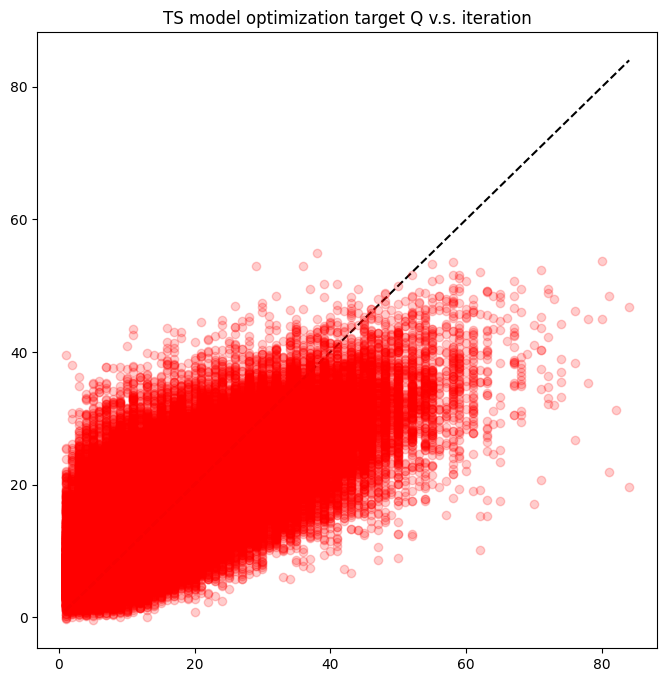

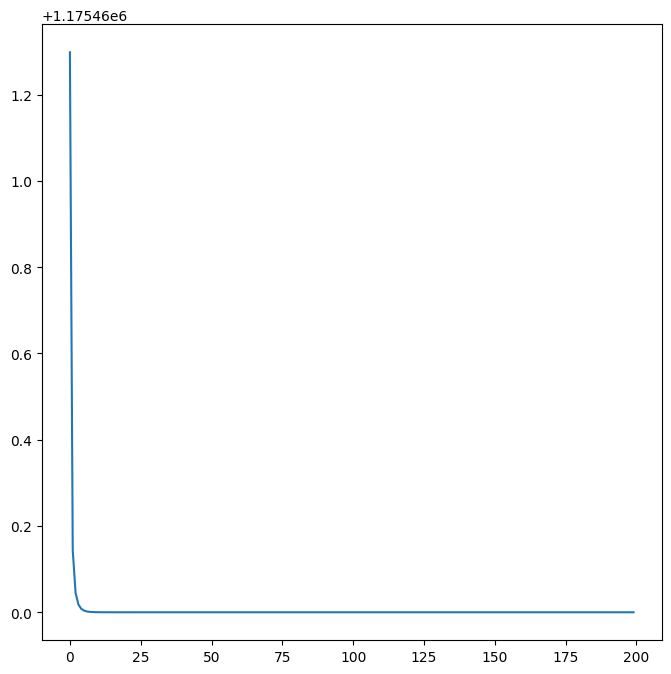

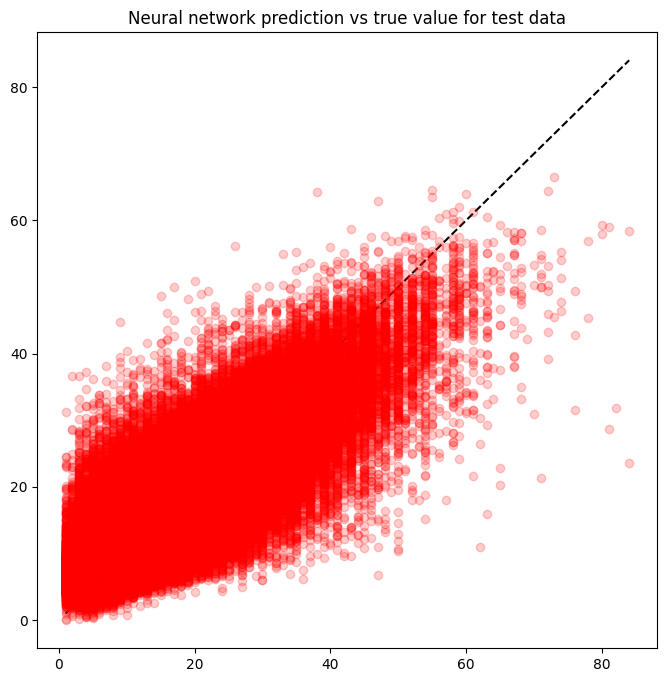

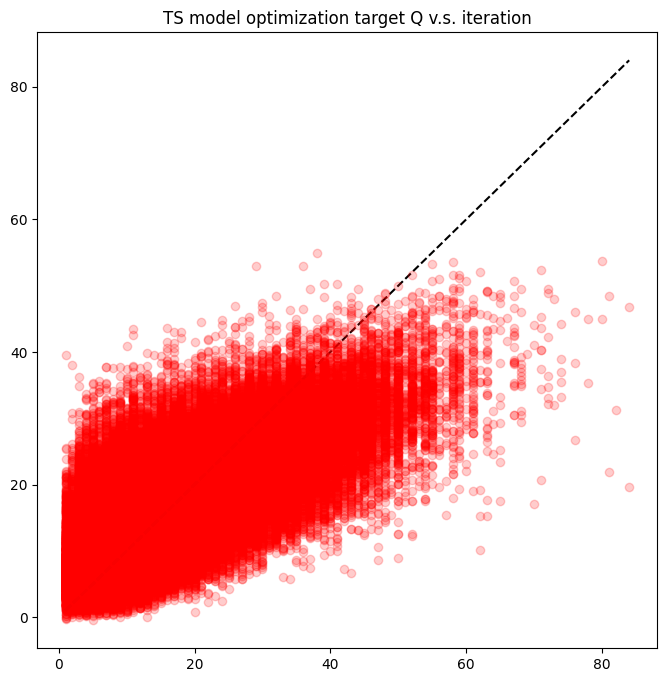

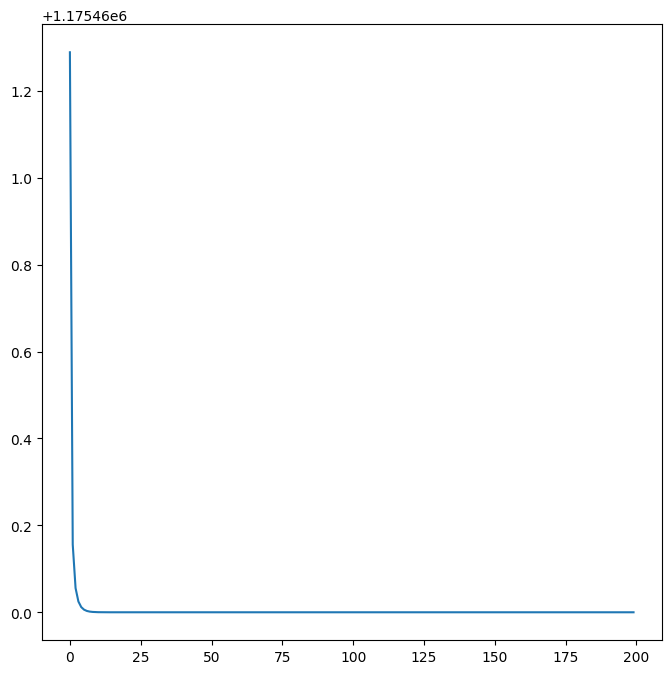

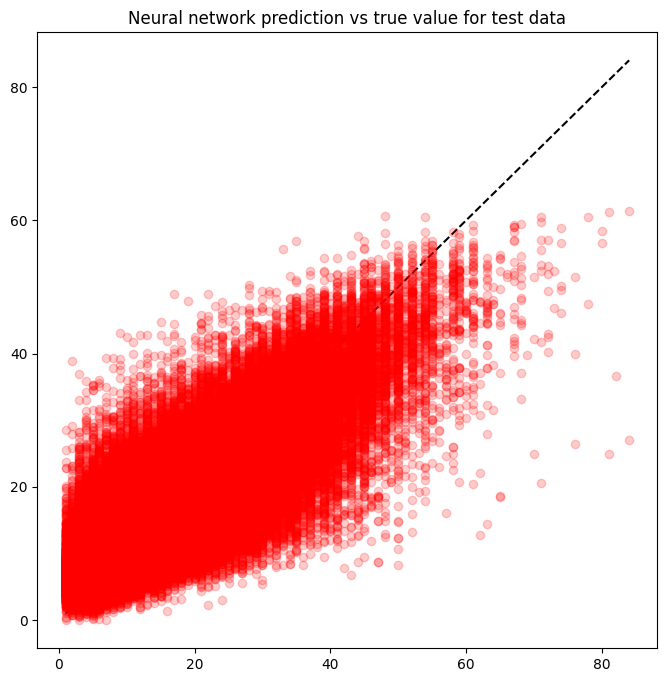

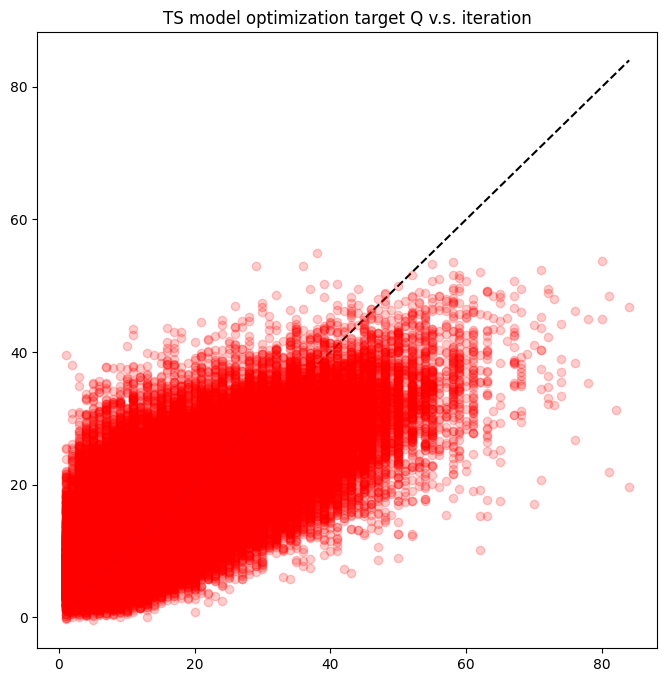

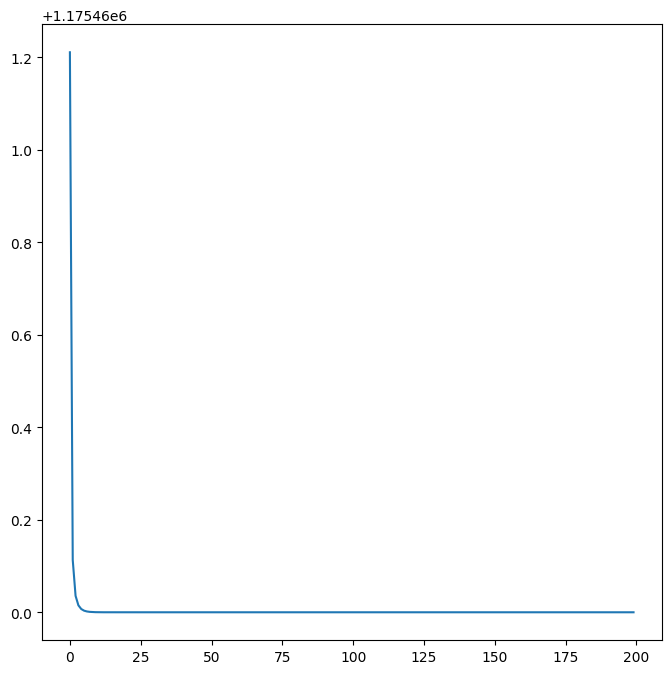

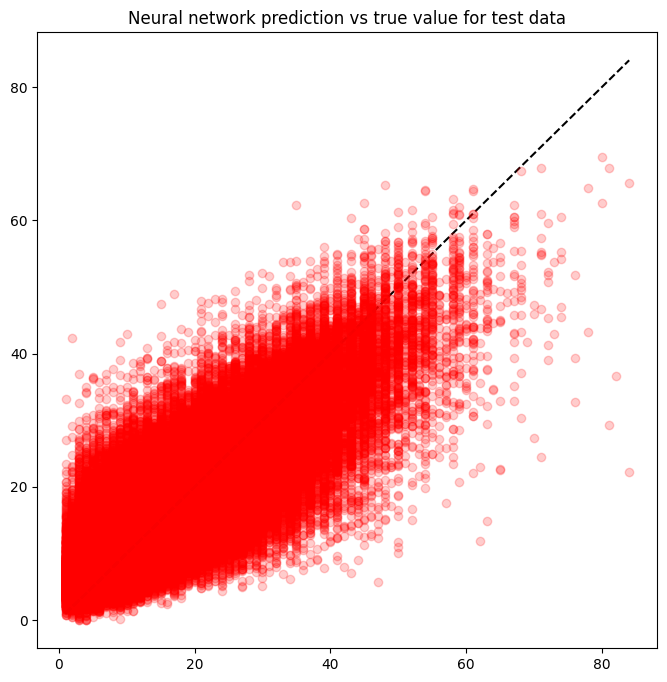

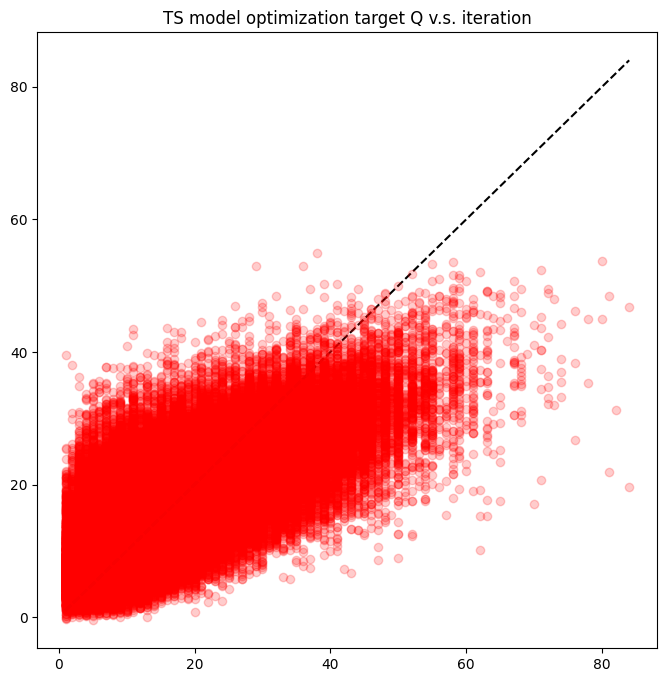

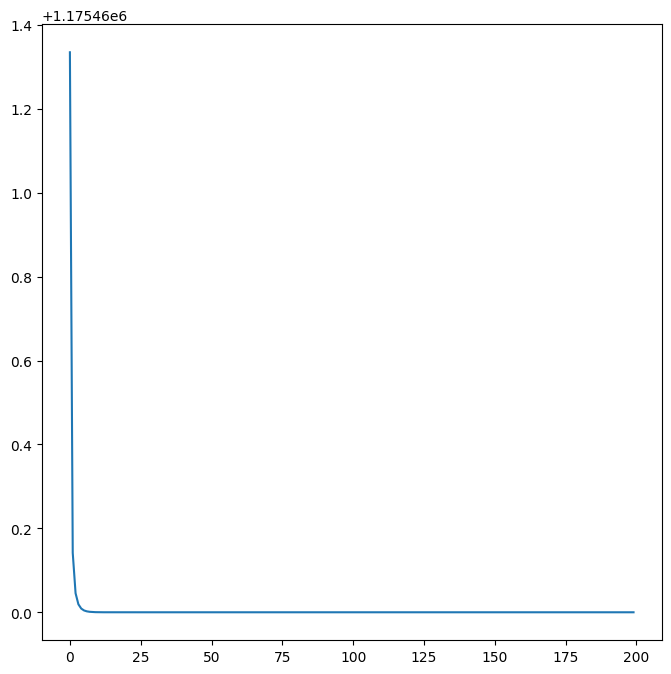

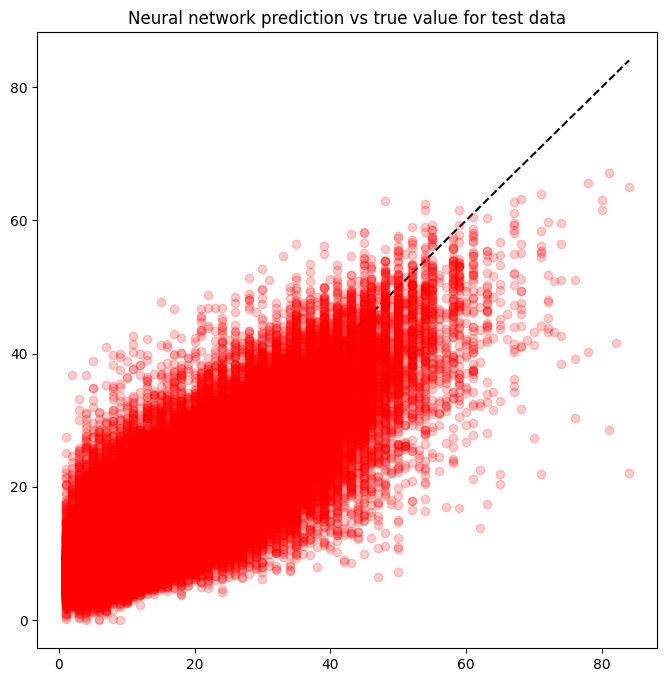

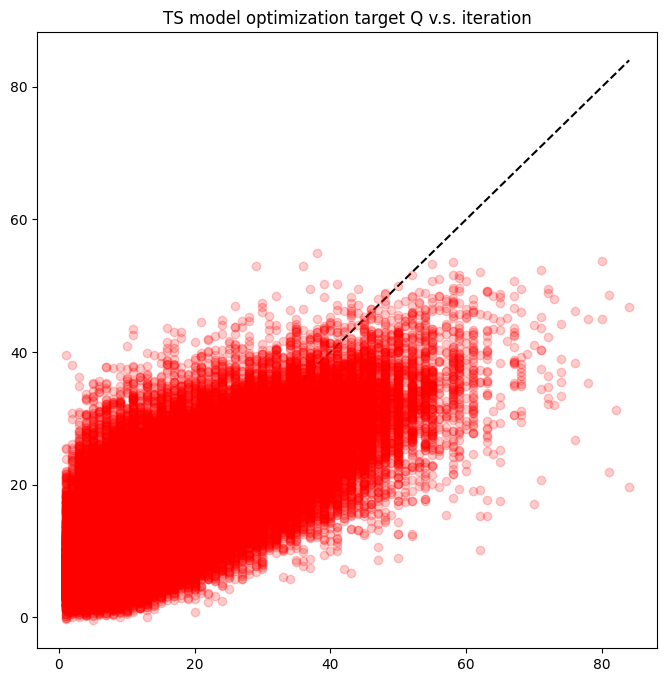

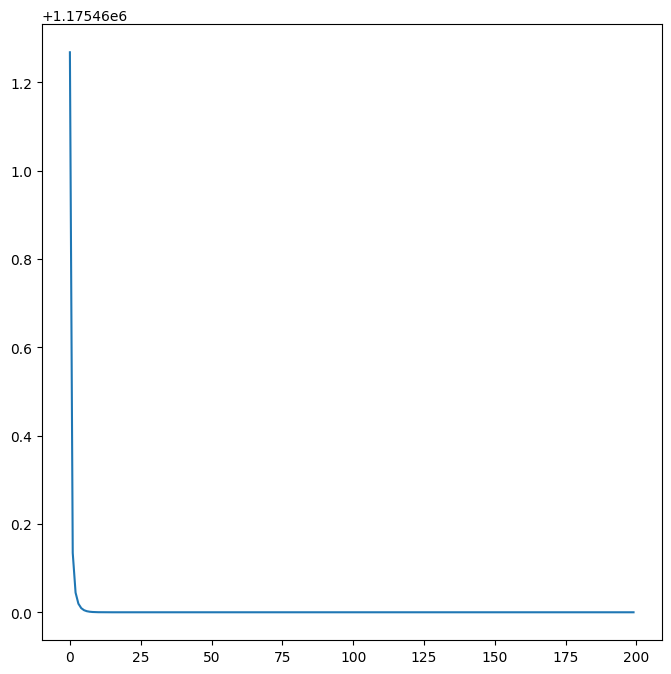

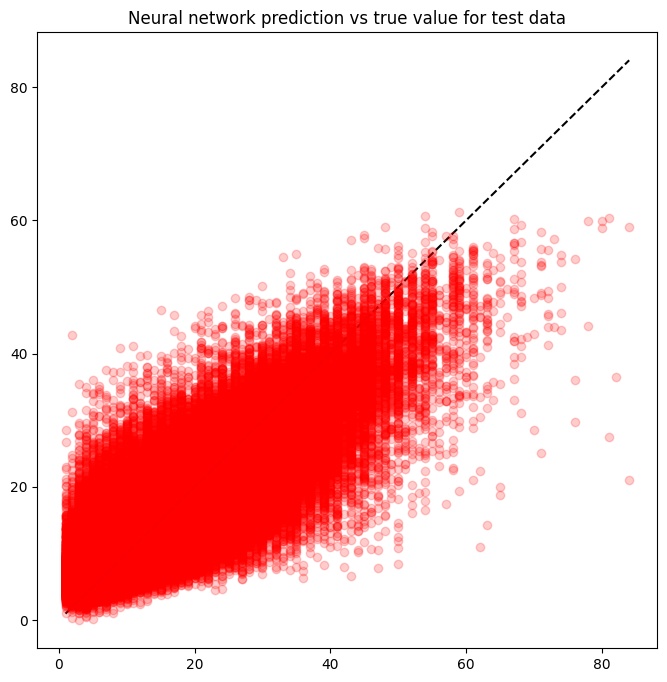

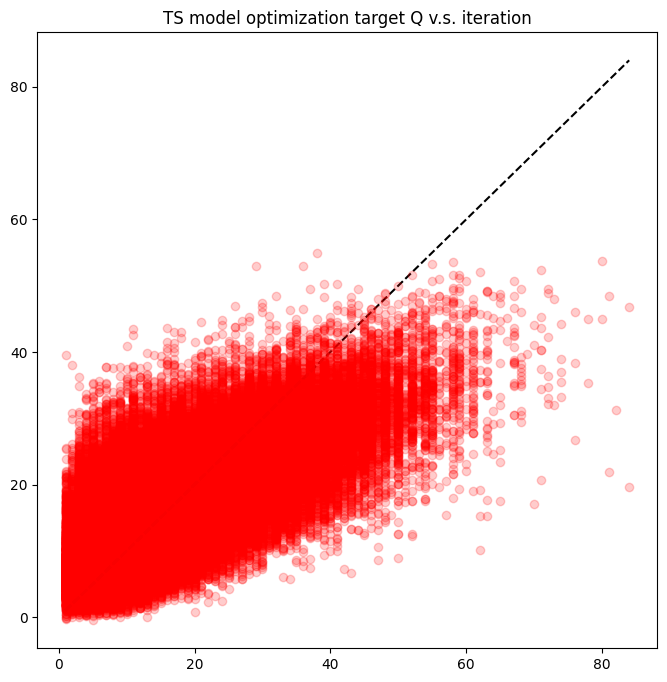

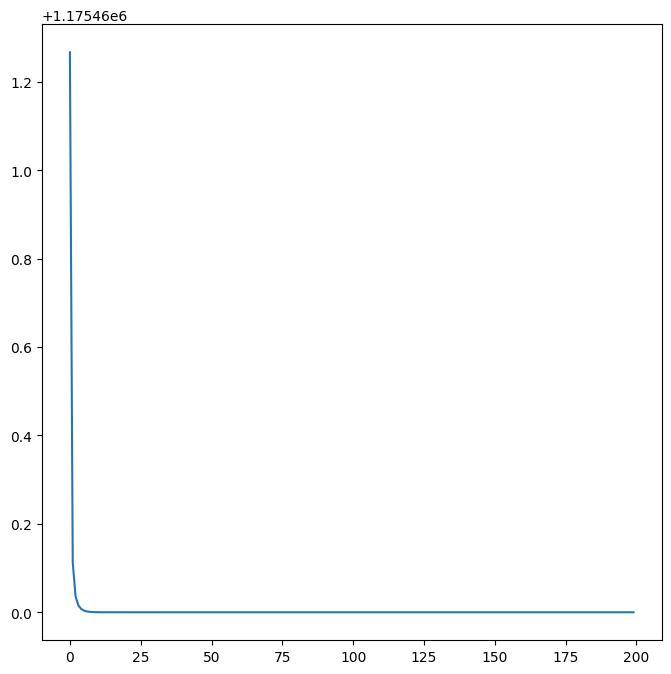

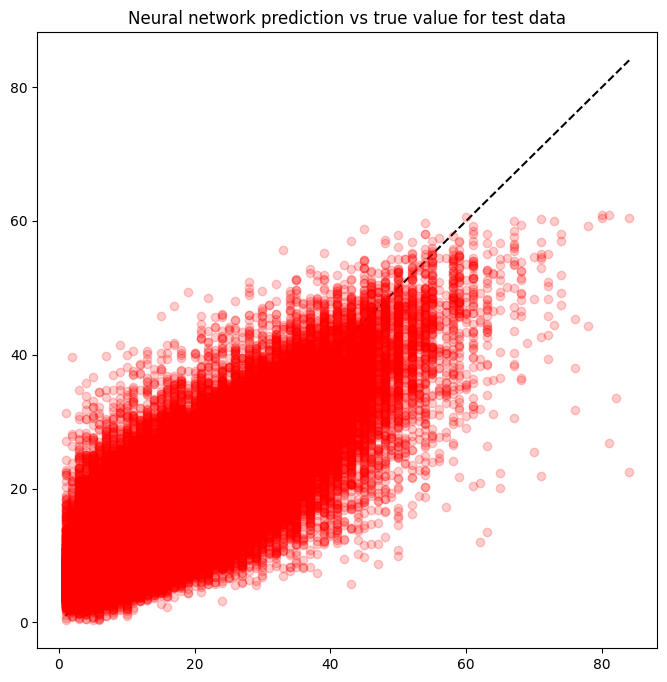

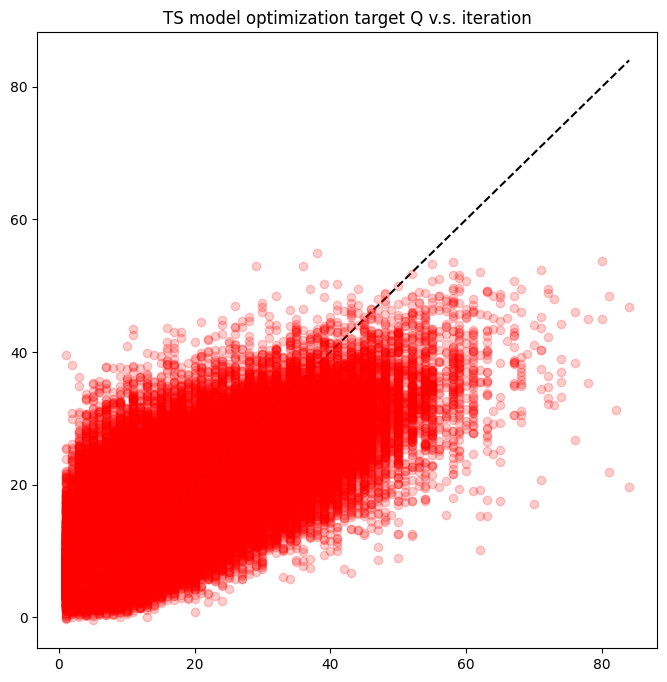

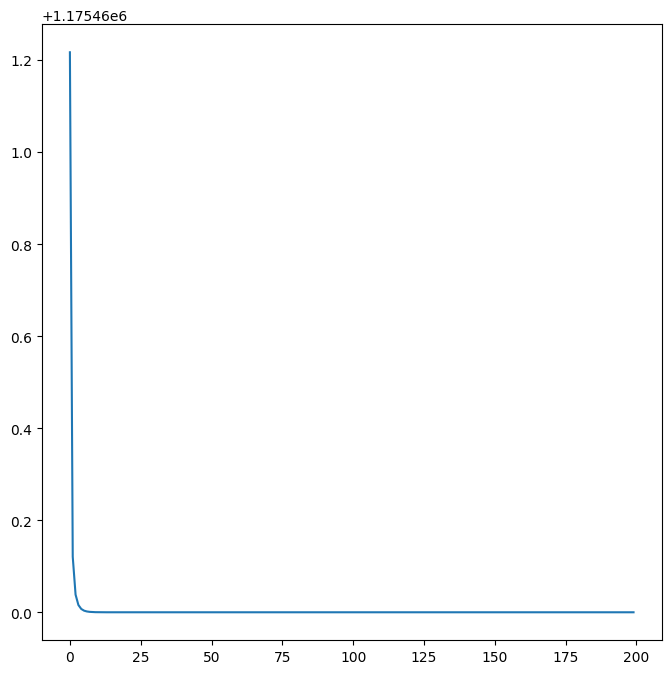

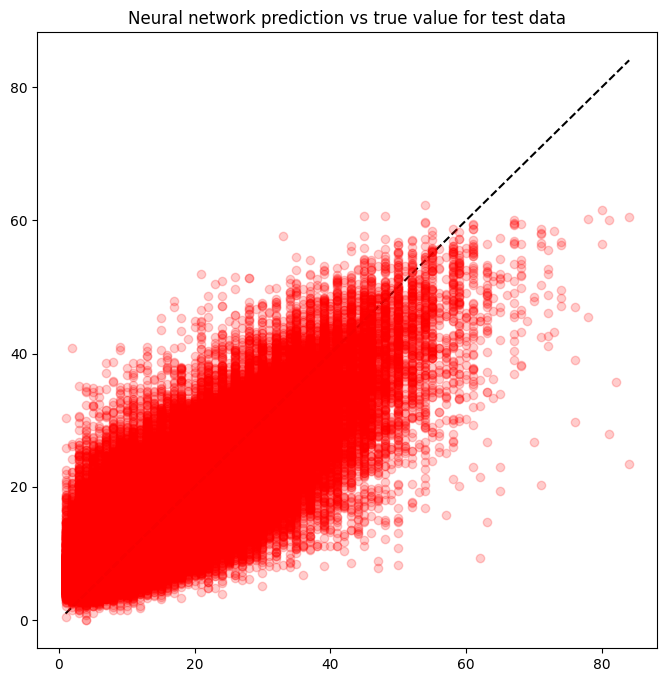

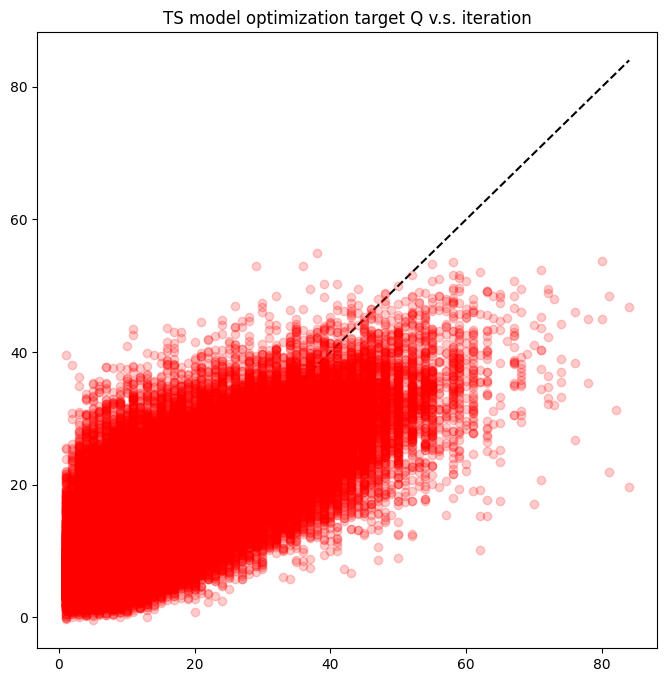

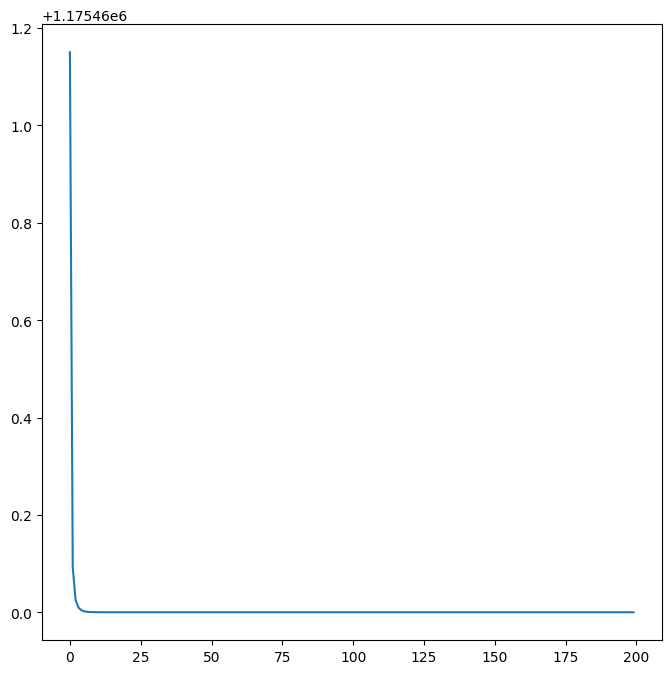

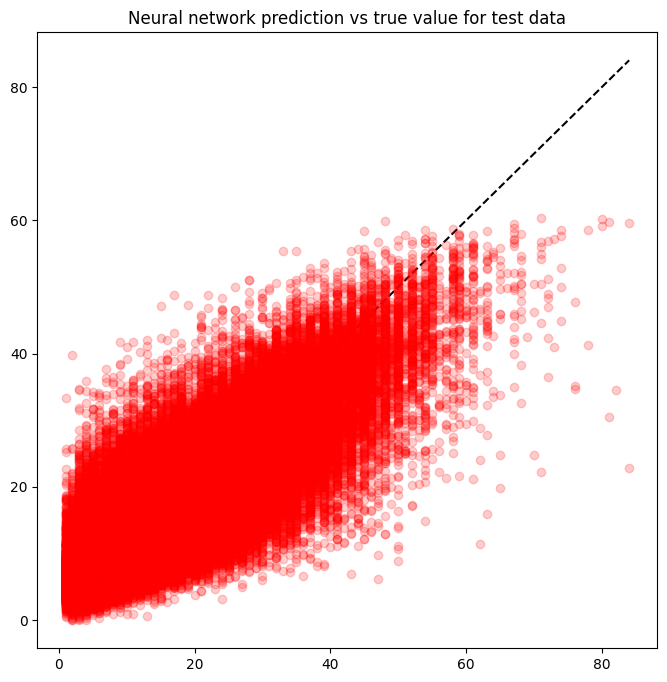

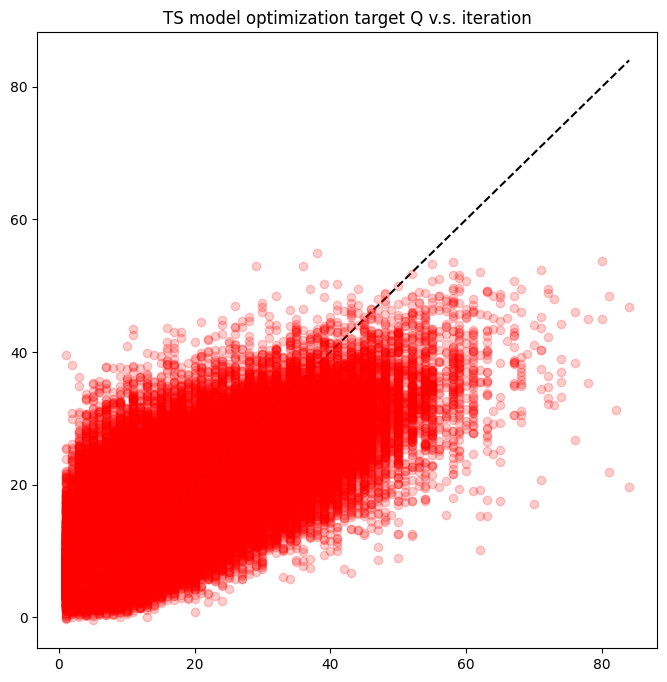

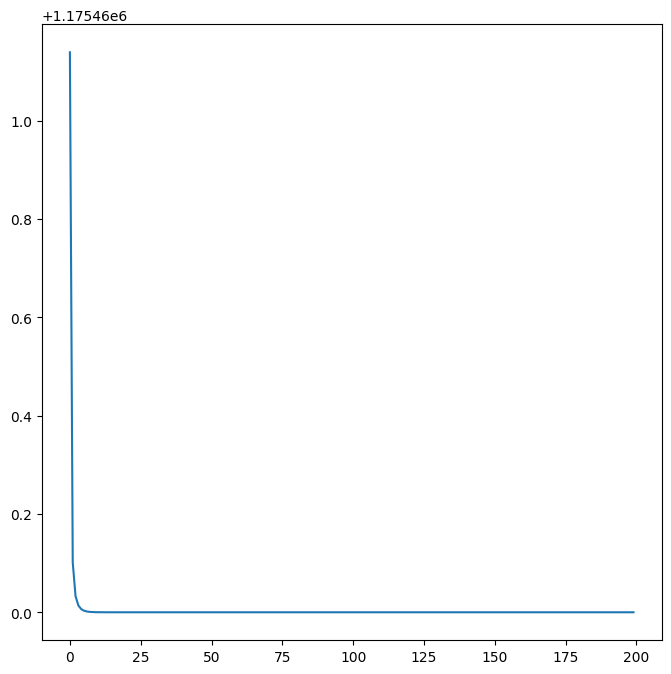

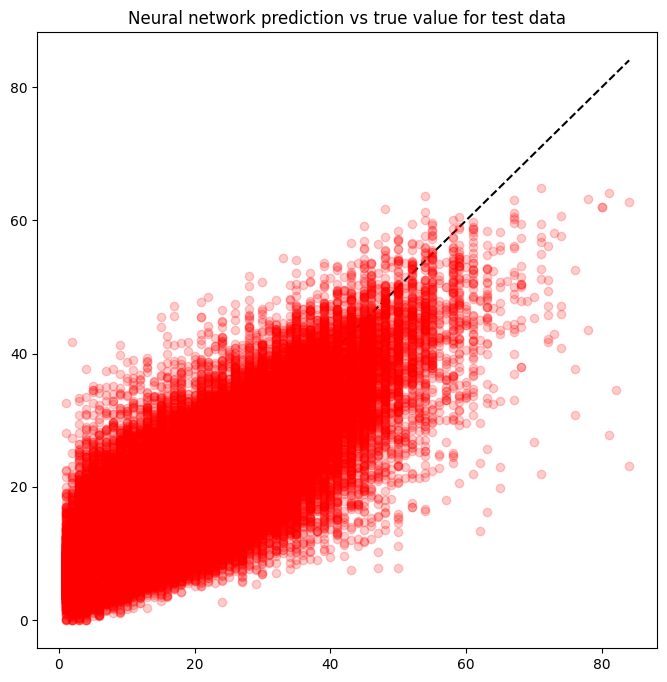

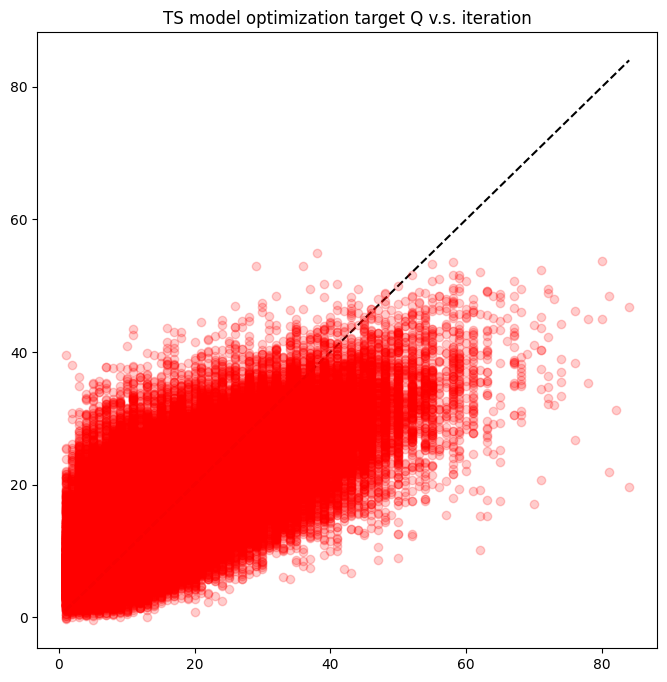

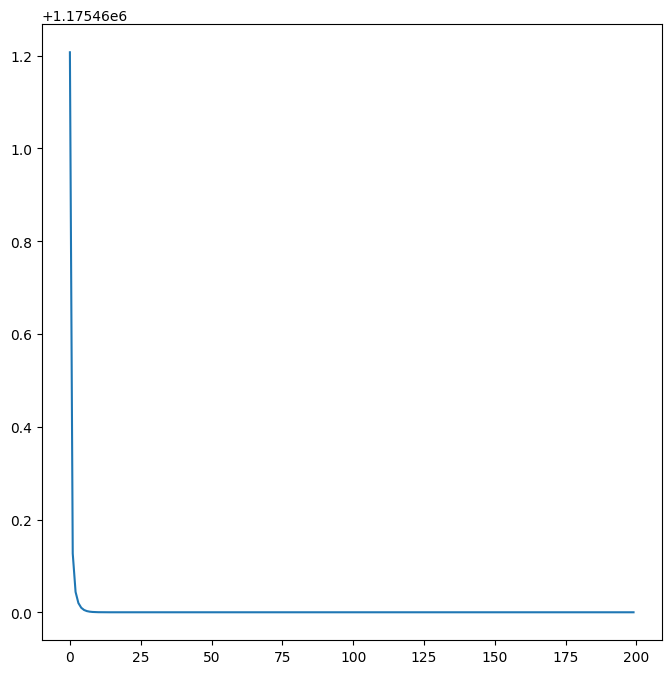

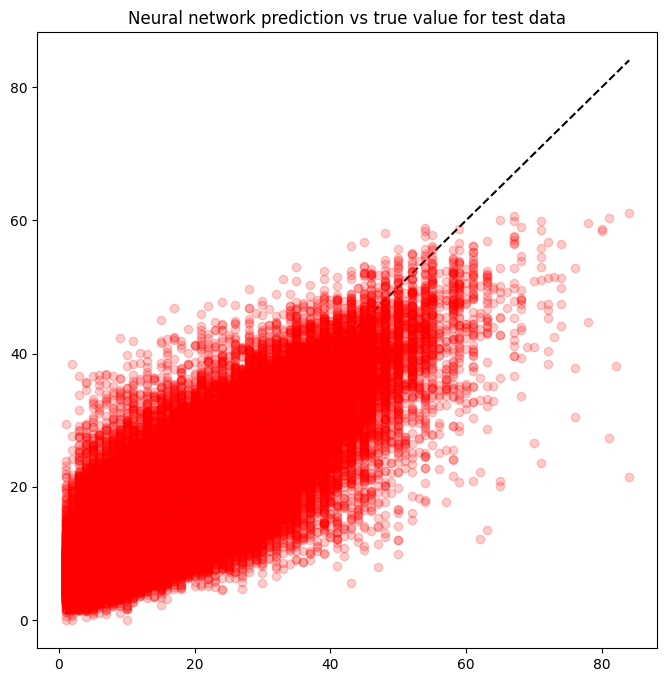

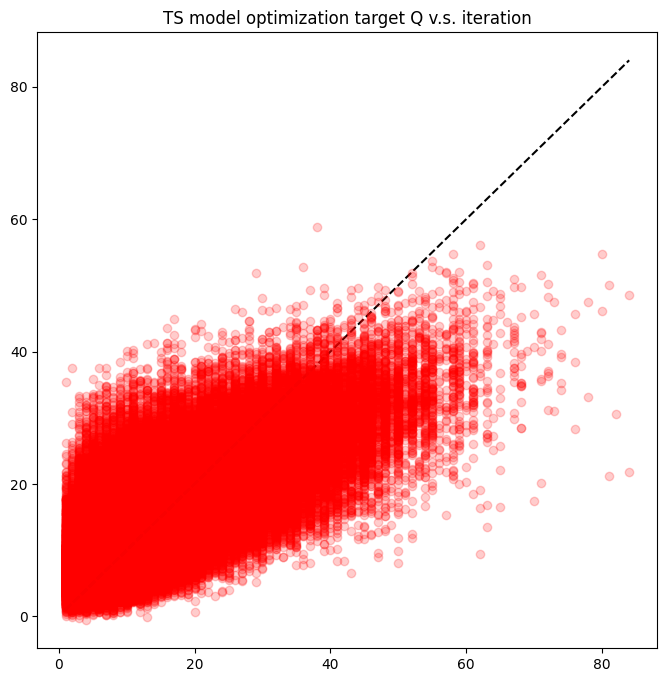

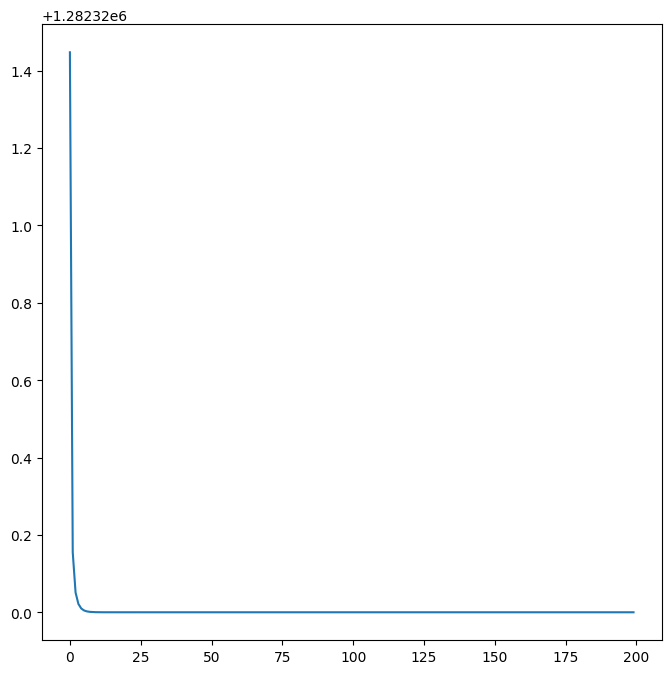

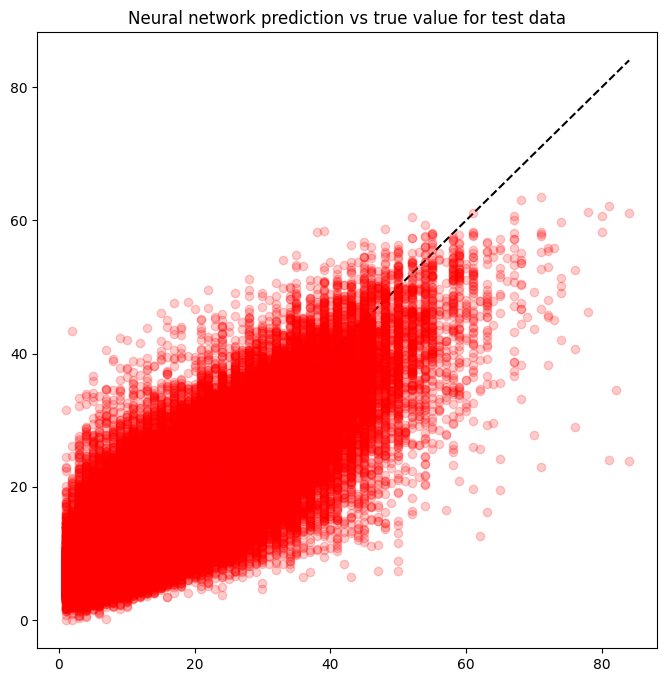

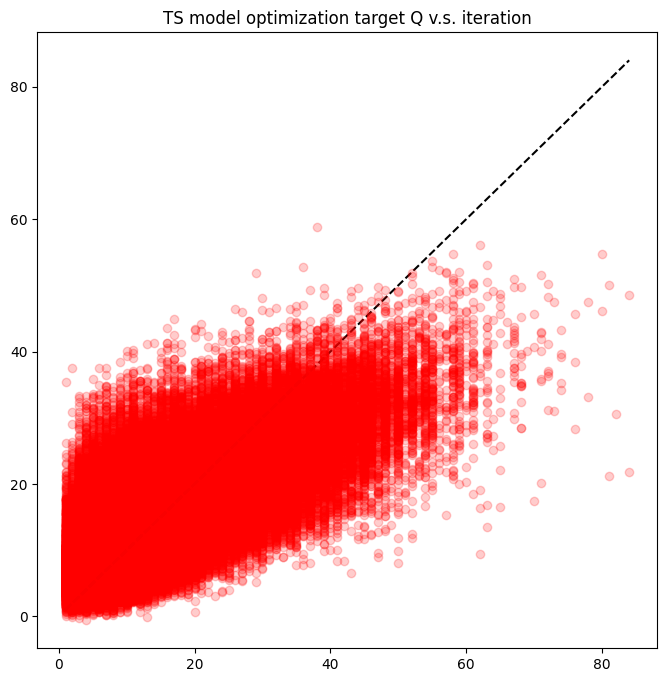

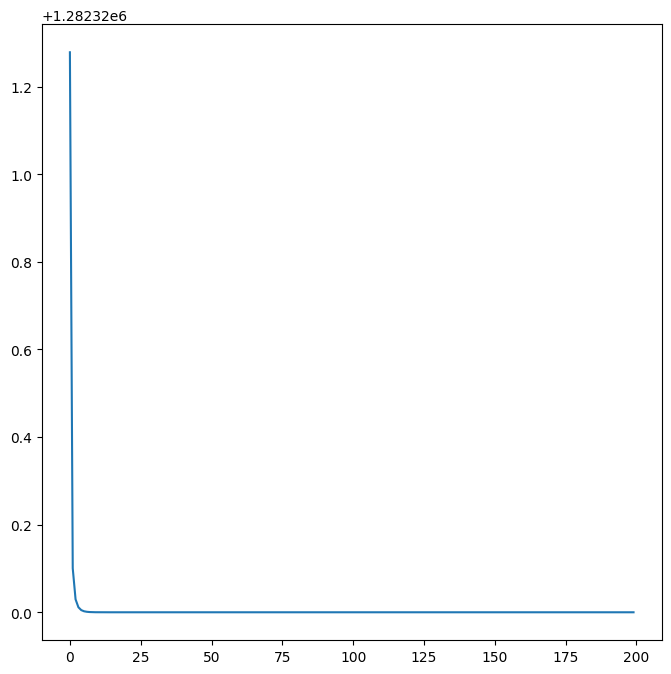

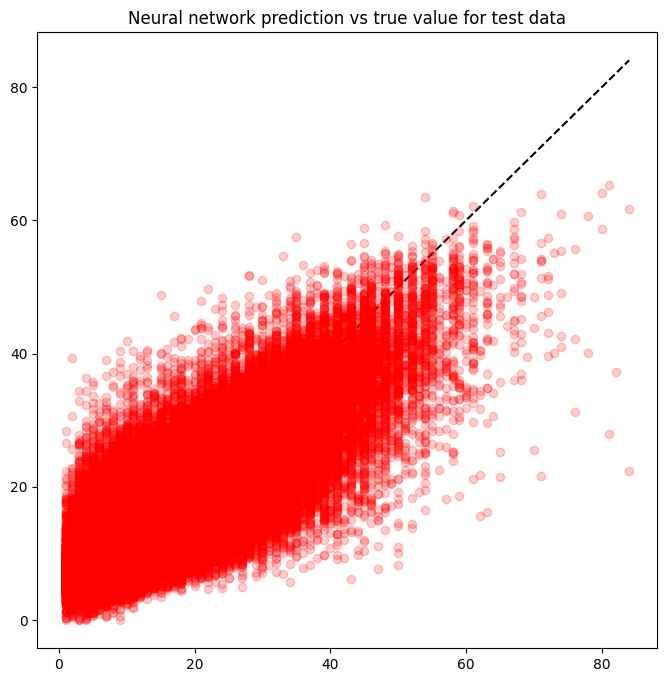

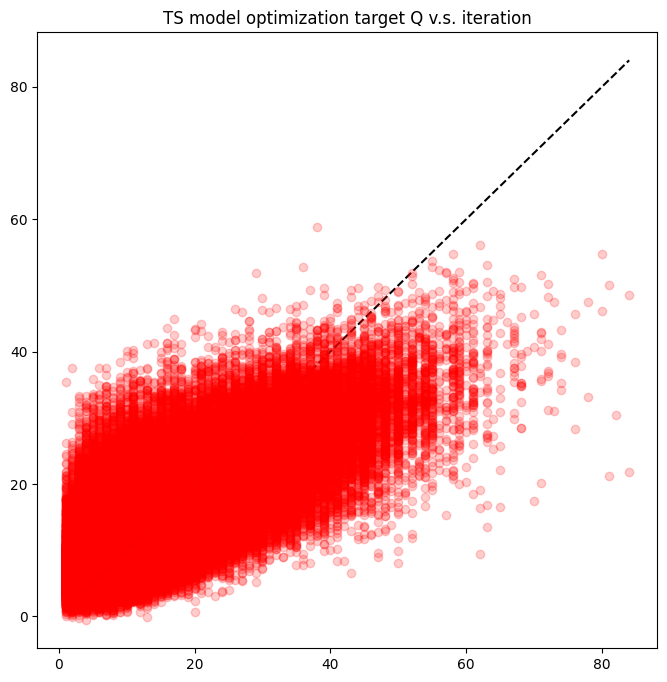

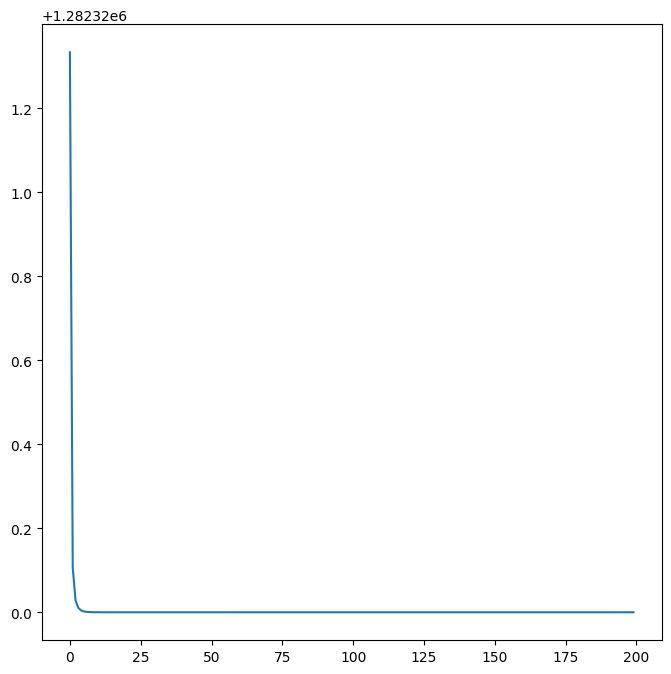

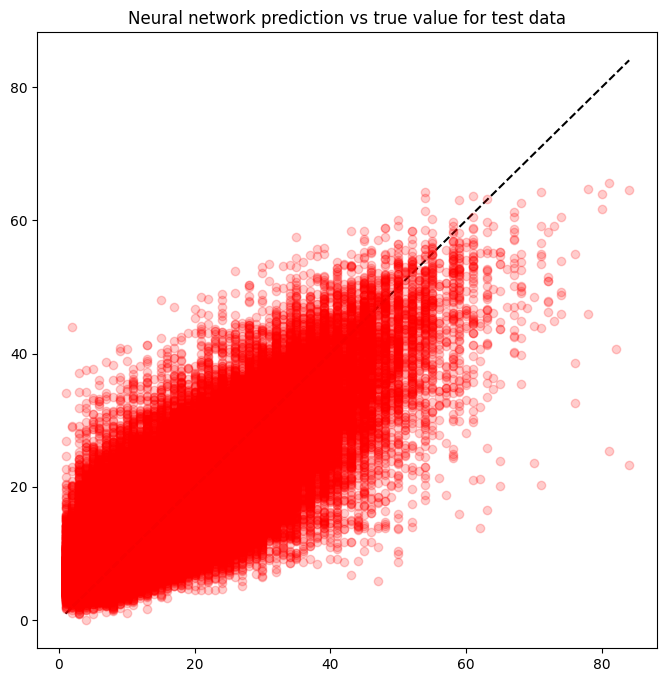

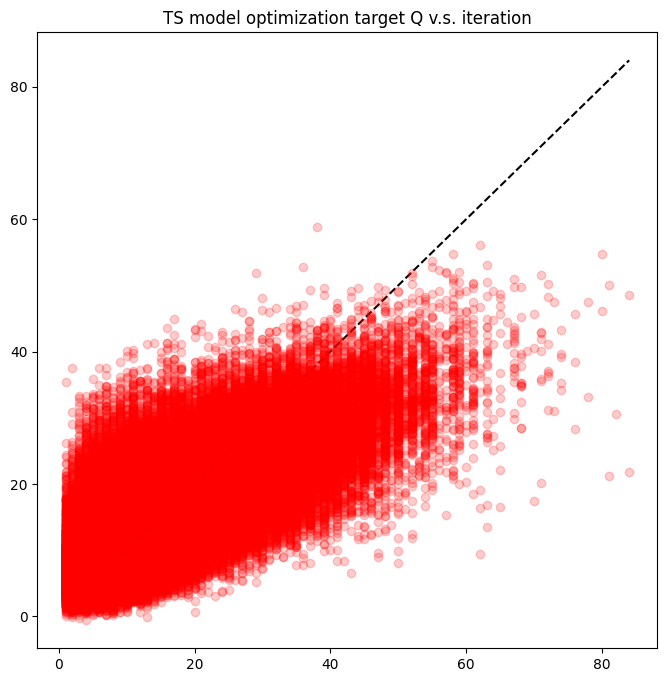

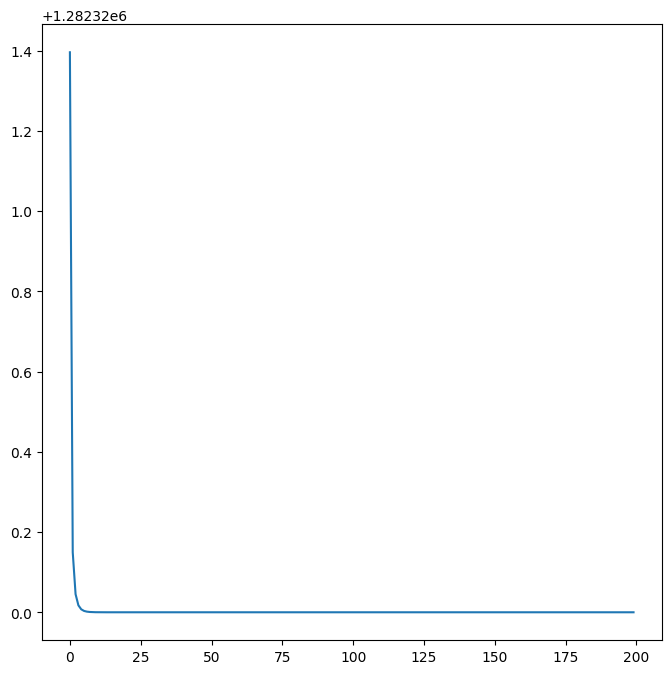

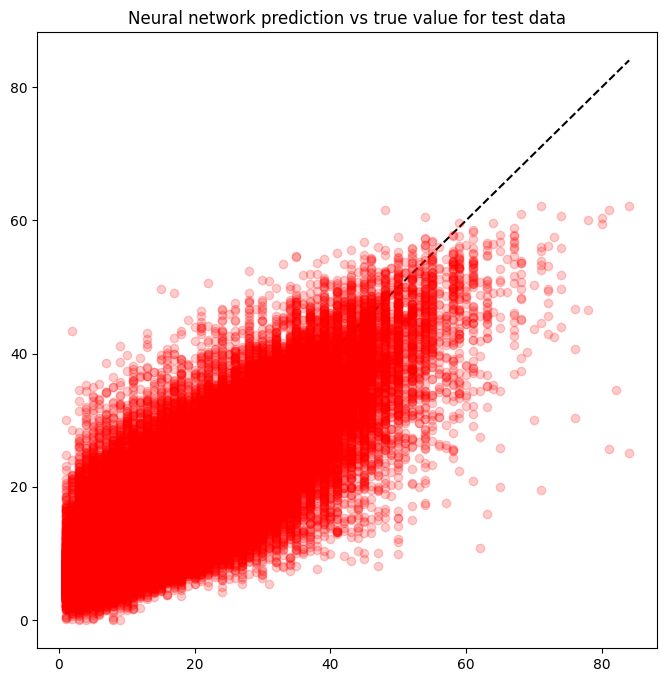

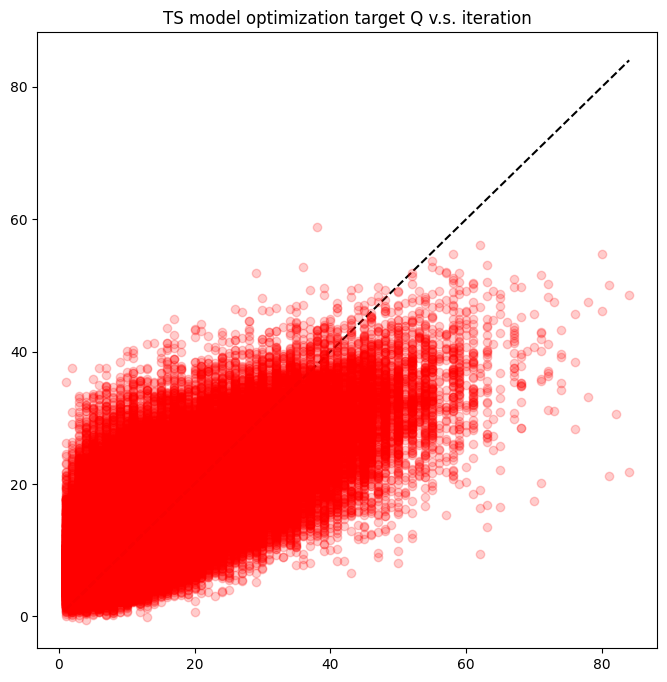

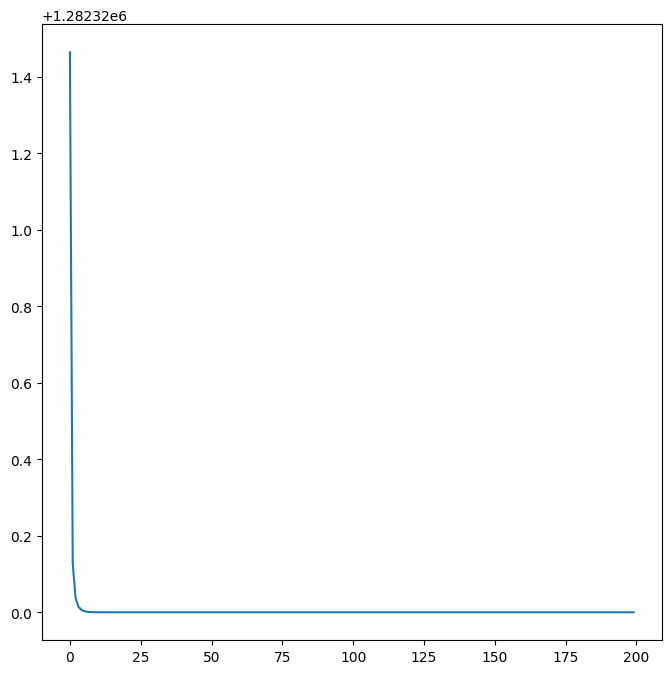

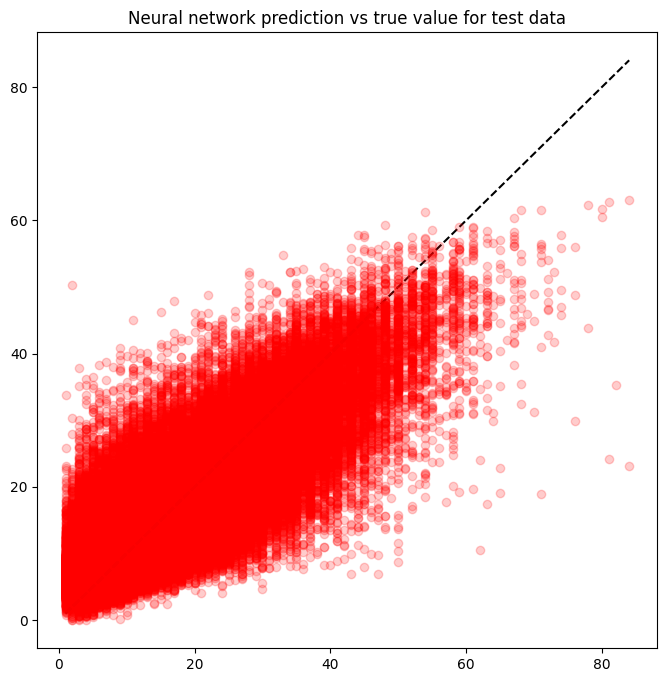

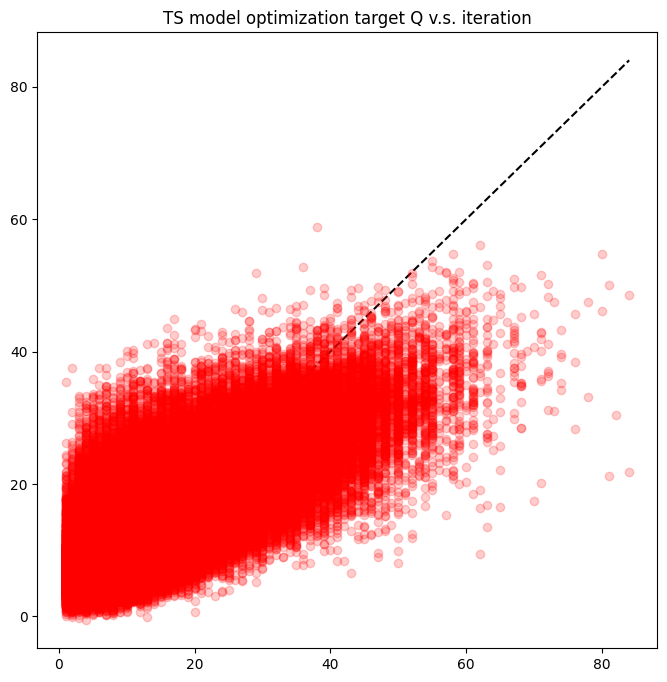

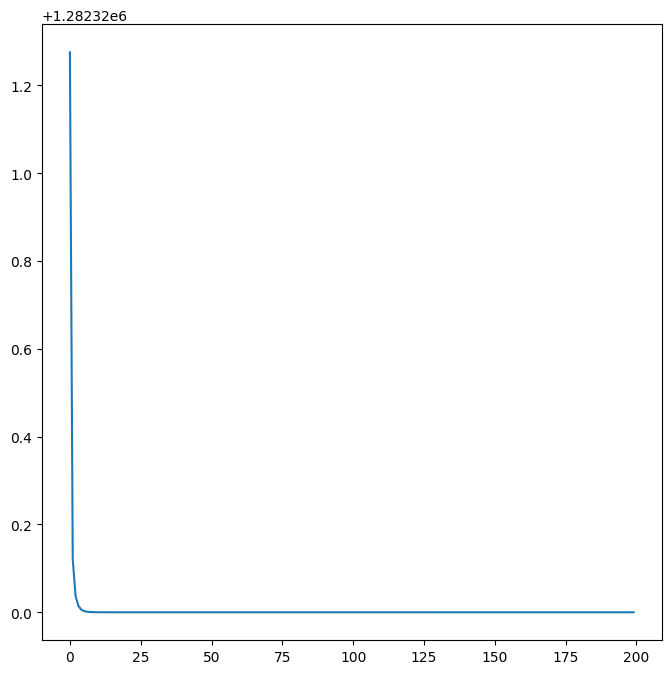

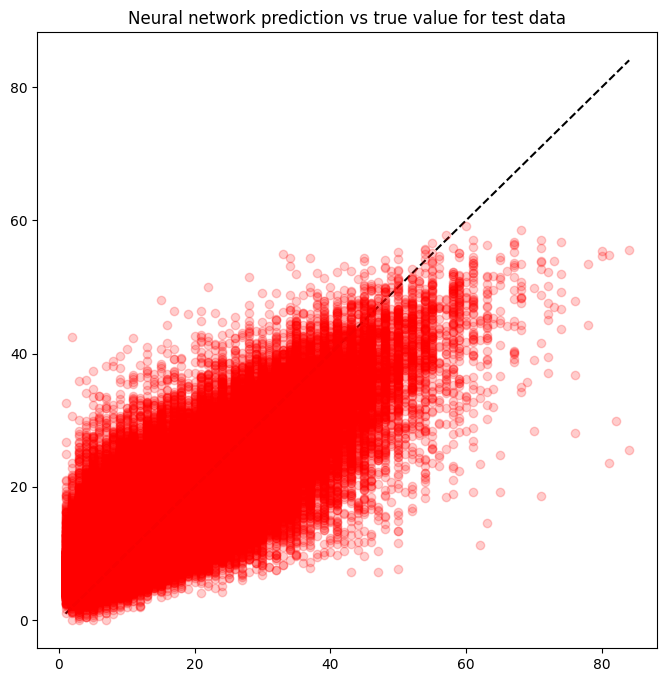

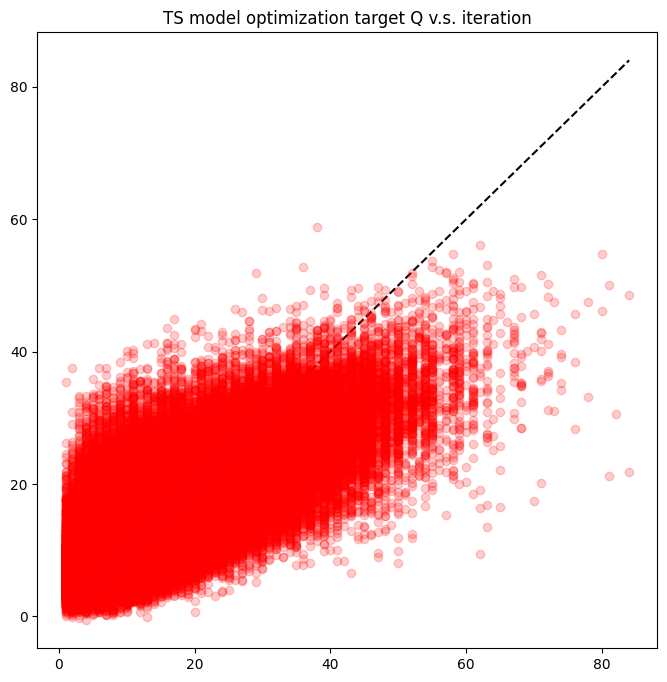

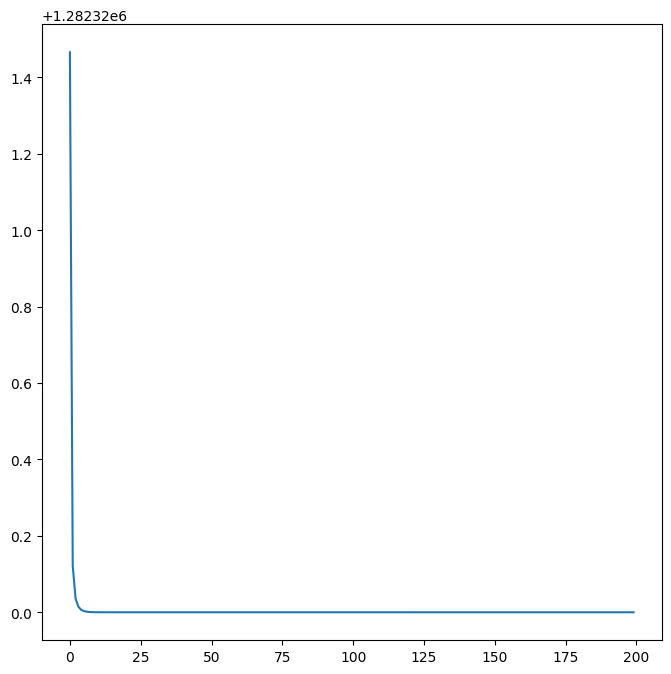

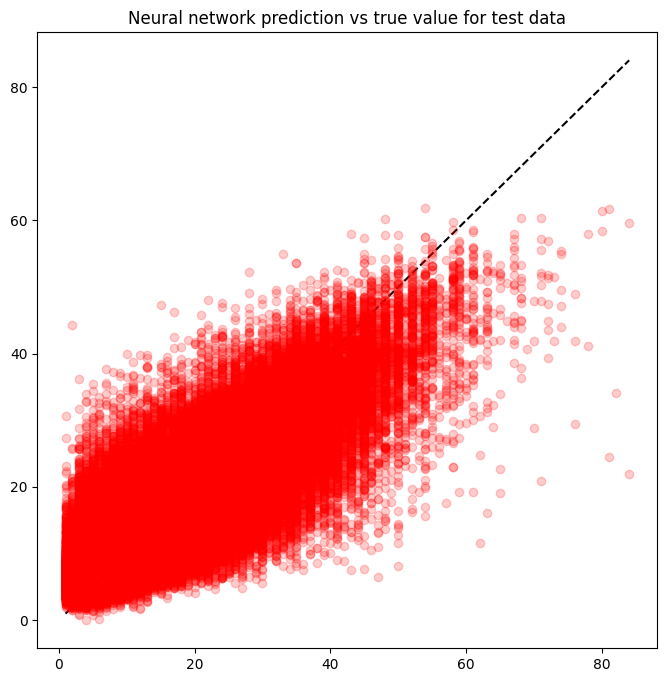

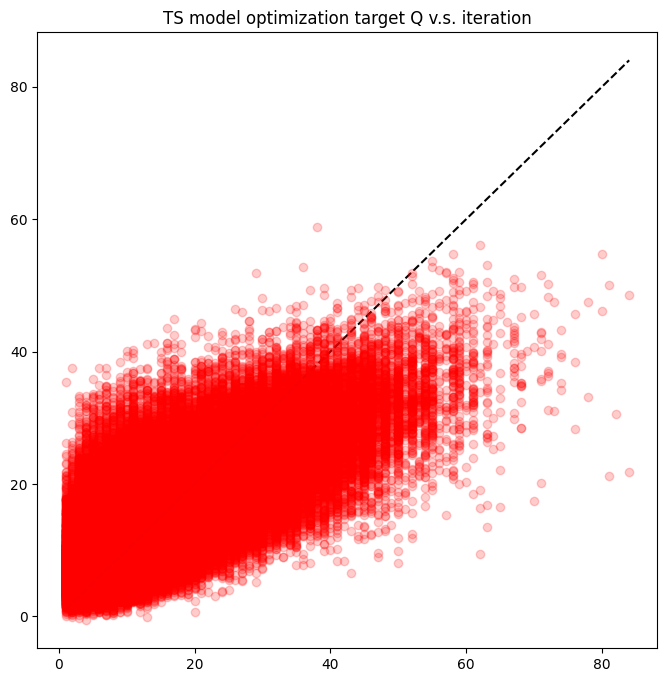

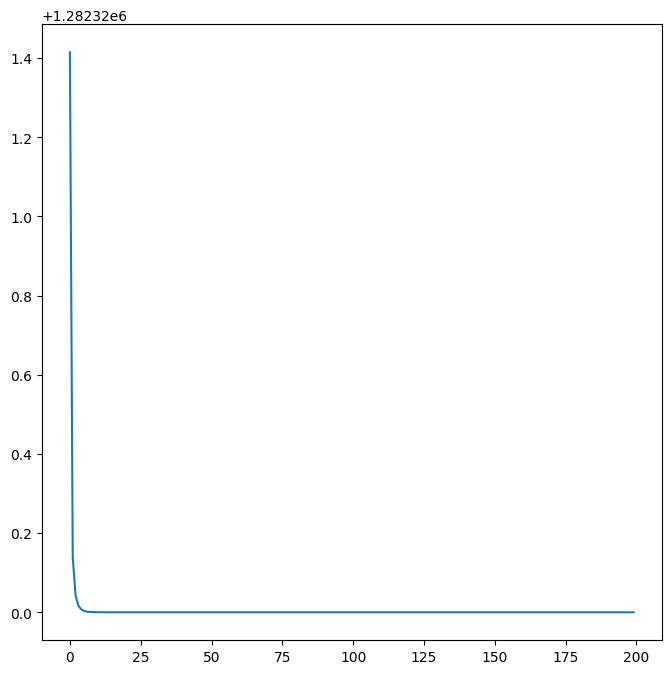

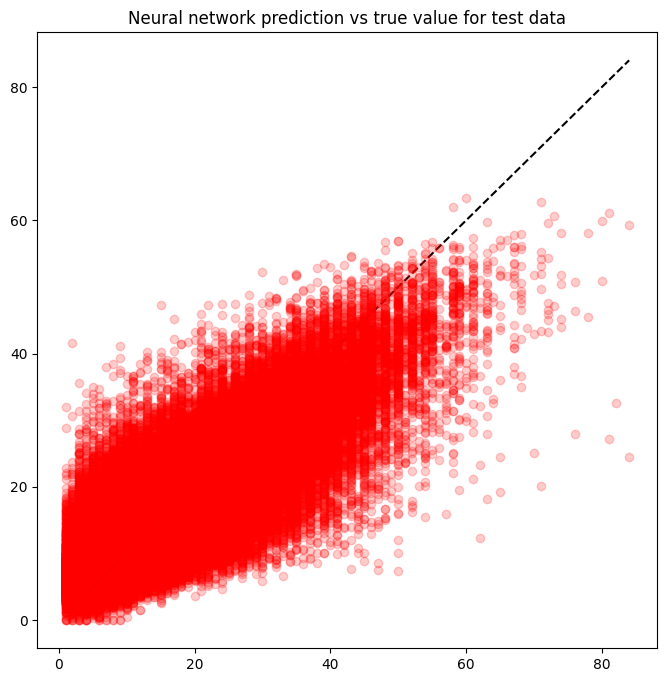

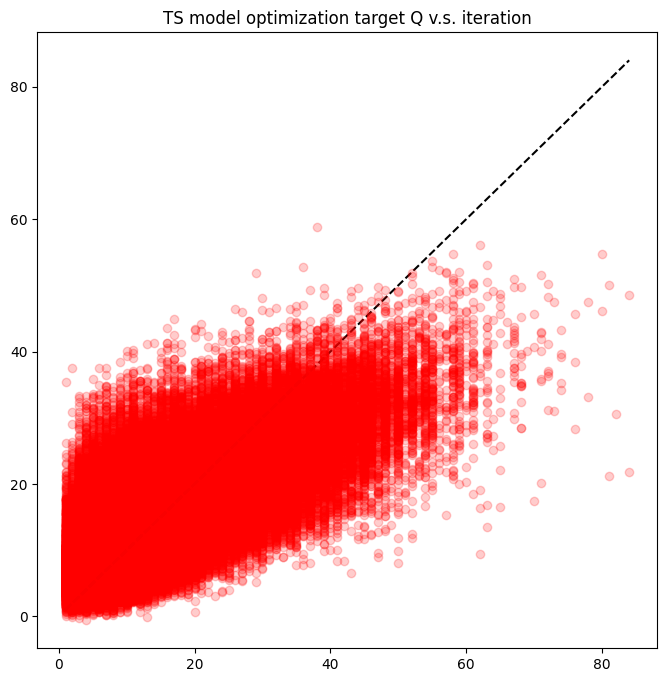

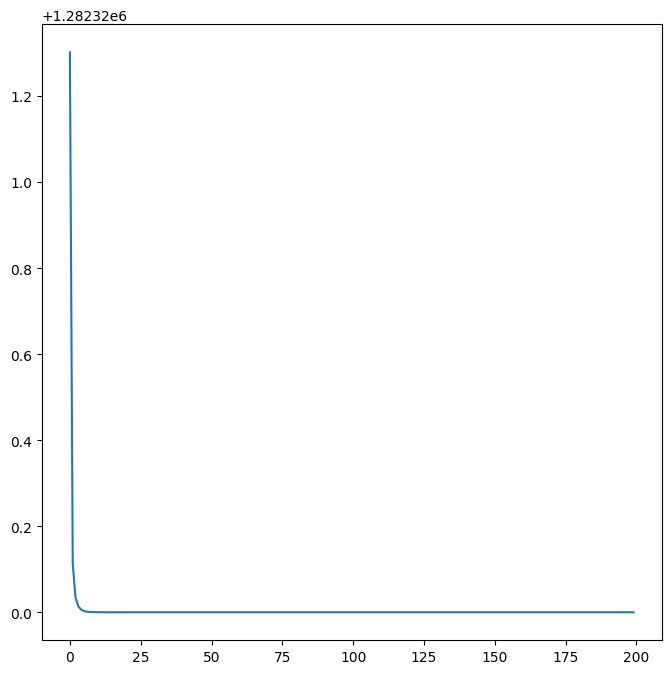

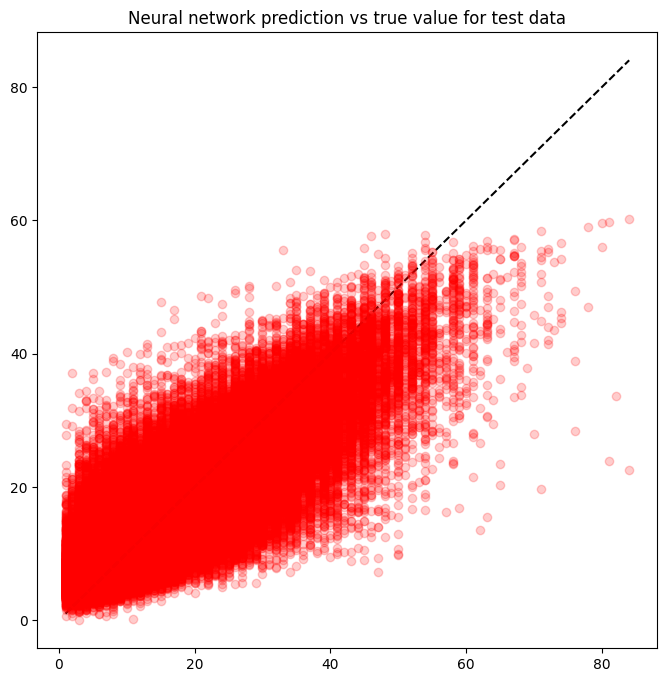

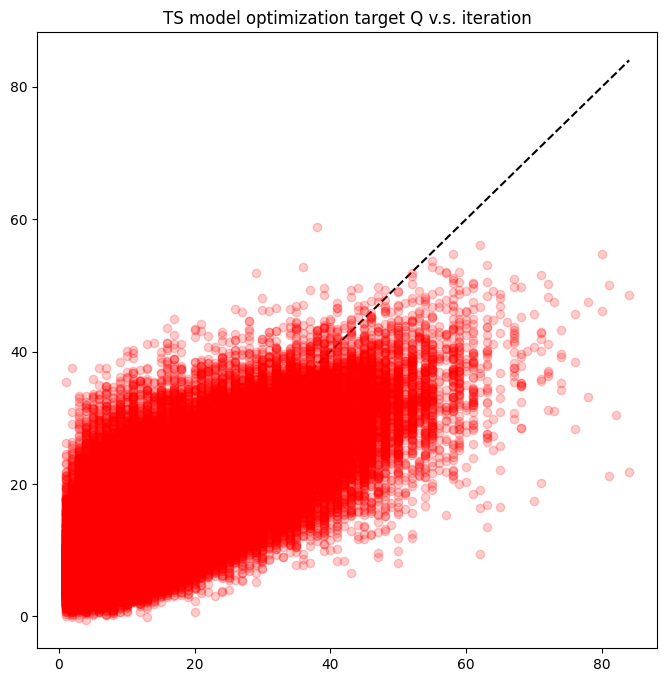

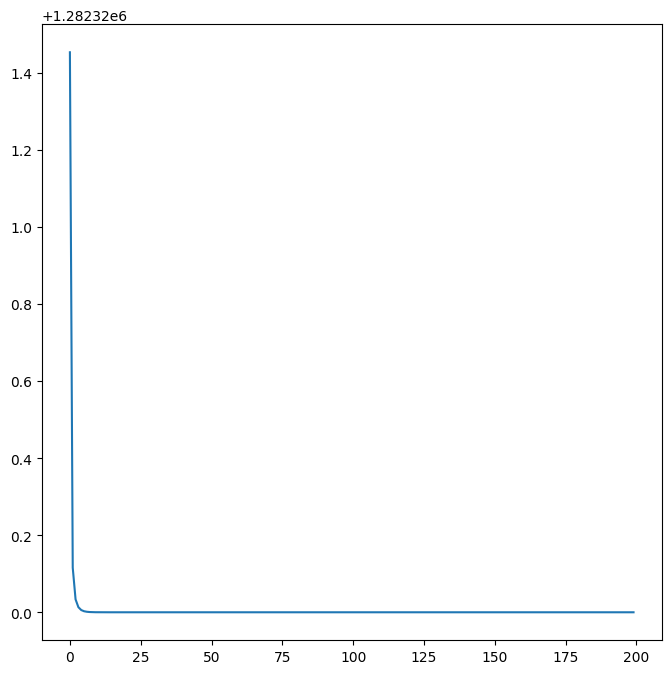

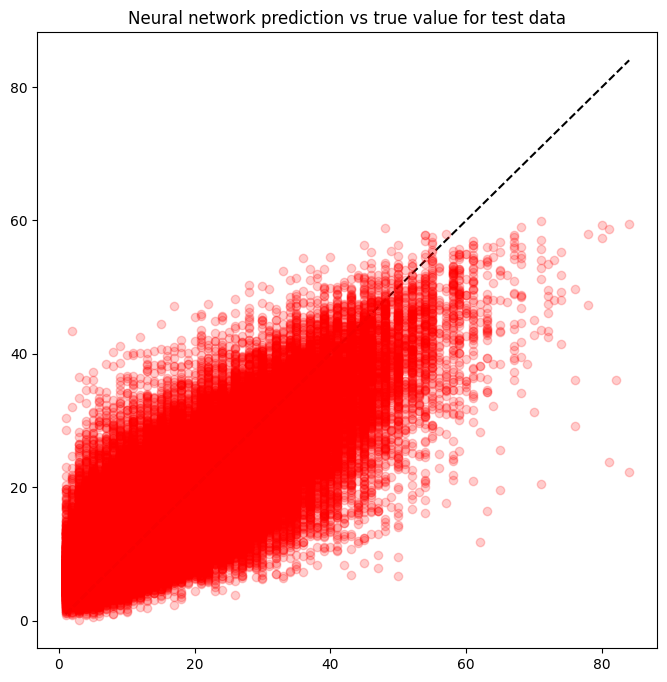

In [27]:
do_experiment(number_of_neighbour_stations, train_data, test_data)

In [55]:
training_results

[[{'linear_train': 7.231147663276162},
  {'fcm_train': 6.776330011623746},
  {'nn_train': 6.237576246261597},
  {'linear_train': 7.231147663276162},
  {'fcm_train': 6.75318834823821},
  {'nn_train': 6.2458023357391355},
  {'linear_train': 7.23114766327616},
  {'fcm_train': 6.782738158646178},
  {'nn_train': 6.255662145614624},
  {'linear_train': 7.231147663276163},
  {'fcm_train': 6.756298508407195},
  {'nn_train': 6.233687028884888},
  {'linear_train': 7.231147663276162},
  {'fcm_train': 6.750540728239406},
  {'nn_train': 6.246402711868286},
  {'linear_train': 7.231147663276161},
  {'fcm_train': 6.754846524828182},
  {'nn_train': 6.245630121231079},
  {'linear_train': 7.231147663276161},
  {'fcm_train': 6.78258962432413},
  {'nn_train': 6.248788843154907},
  {'linear_train': 7.231147663276161},
  {'fcm_train': 6.781559827269206},
  {'nn_train': 6.248208236694336},
  {'linear_train': 7.231147663276162},
  {'fcm_train': 6.795717449323004},
  {'nn_train': 6.257223634719849},
  {'linear_t

exp
7.2311±0.0
6.7706±0.015
6.2463±0.0068
exp
7.0071±0.0
6.7166±0.0
5.8777±0.0068
exp
6.9039±0.0
6.1219±0.0262
5.6055±0.0053
exp
6.6041±0.0
6.6041±0.0
5.5082±0.0067
exp
6.4277±0.0
6.4277±0.0
5.4781±0.0045
exp
6.4203±0.0
6.4203±0.0
5.4465±0.0047
exp
6.456±0.0
6.456±0.0
5.4597±0.0055
exp
6.5277±0.0
6.5277±0.0
5.446±0.0046
exp
6.452±0.0
6.452±0.0
5.4436±0.0054
exp
6.4835±0.0
6.4834±0.0
5.6134±0.4956
exp
6.5401±0.0
6.54±0.0
5.454±0.0081
exp
6.5716±0.0001
6.5715±0.0
5.4622±0.0114


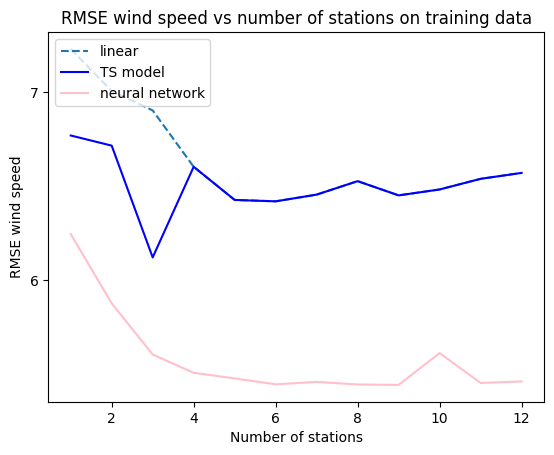

In [28]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7202)
# fcm_train_plot.insert(1, 6.6459)
# nn_train_plot.insert(1, 5.8963)

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on training data')

for exp in training_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


exp
7.2407±0.0
6.7804±0.0128
6.235±0.0081
exp
7.0117±0.0
6.7255±0.0
5.8649±0.0073
exp
6.916±0.0
6.1403±0.0276
5.5969±0.0055
exp
6.6074±0.0
6.6074±0.0
5.5032±0.0077
exp
6.4329±0.0
6.4329±0.0
5.4698±0.0053
exp
6.4353±0.0
6.4353±0.0
5.4486±0.0058
exp
6.4589±0.0
6.4589±0.0
5.4641±0.0054
exp
6.5369±0.0
6.5368±0.0
5.4522±0.0037
exp
6.4553±0.0
6.4552±0.0
5.4465±0.0048
exp
6.4915±0.0
6.4915±0.0
5.6232±0.5039
exp
6.5555±0.0001
6.5554±0.0
5.4636±0.0075
exp
6.5839±0.0001
6.5838±0.0
5.4686±0.0078


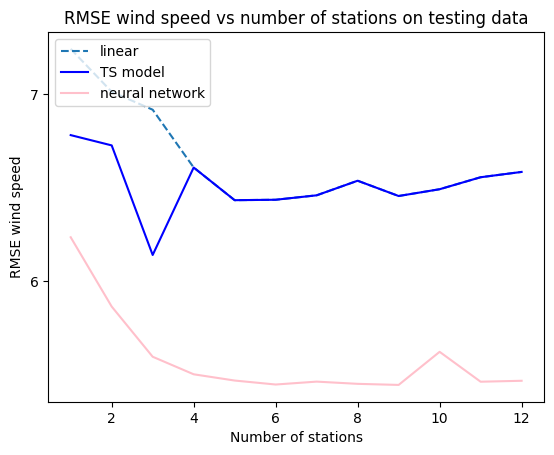

In [32]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in test_results:
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7219)
# fcm_train_plot.insert(1, 6.6489)
# nn_train_plot.insert(1, 5.9011)


plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on testing data')

for exp in test_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")


In [49]:
training_times[9]

[{'linear_train': 1.233834981918335},
 {'fcm_train': 168.52606558799744},
 {'nn_train': 1426.8141462802887},
 {'linear_train': 1.1243205070495605},
 {'fcm_train': 167.27157425880432},
 {'nn_train': 1418.7499465942383},
 {'linear_train': 1.1265807151794434},
 {'fcm_train': 168.77304100990295},
 {'nn_train': 1422.0740575790405},
 {'linear_train': 1.1239032745361328},
 {'fcm_train': 167.49027013778687},
 {'nn_train': 1422.0440649986267},
 {'linear_train': 1.1374692916870117},
 {'fcm_train': 167.3704378604889},
 {'nn_train': 1425.1562218666077},
 {'linear_train': 1.1460168361663818},
 {'fcm_train': 167.51256680488586},
 {'nn_train': 1423.4568648338318},
 {'linear_train': 1.1390972137451172},
 {'fcm_train': 167.8305516242981},
 {'nn_train': 1410.3228833675385},
 {'linear_train': 1.2554047107696533},
 {'fcm_train': 167.51797580718994},
 {'nn_train': 1415.3795566558838},
 {'linear_train': 1.1346375942230225},
 {'fcm_train': 167.81351947784424},
 {'nn_train': 1423.5536696910858},
 {'linear_tra

[0.05779542922973633, 0.10512628555297851, 0.18140747547149658, 0.257893967628479, 0.3837465763092041, 0.46598703861236573, 0.5797907590866089, 0.7263056039810181, 0.9430693864822388, 1.158401608467102, 1.3563196659088135, 1.5057610273361206]
[131.03713357448578, 109.08597023487091, 116.40648560523987, 123.42344617843628, 127.10050435066223, 135.3686448097229, 141.49408173561096, 150.10453343391418, 158.57835369110109, 167.88107867240905, 177.2185900449753, 186.64140989780427]
[1611.671659898758, 1415.5011890411376, 1420.4644891500473, 1419.133735704422, 1420.8603631973267, 1410.7465843439102, 1394.5273993253709, 1394.9660172224044, 1414.7745237350464, 1419.8697877645493, 1412.235040140152, 1381.624940085411]


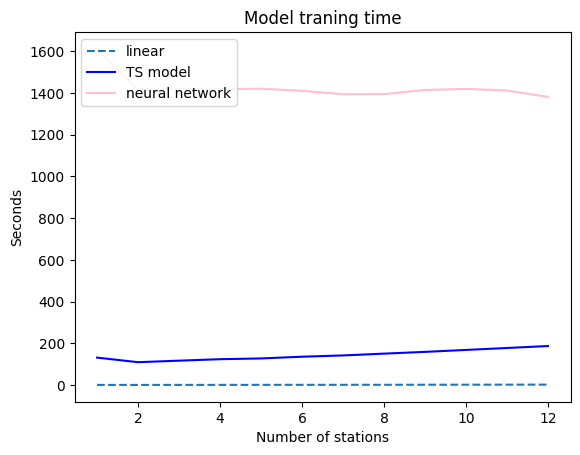

In [34]:
li_time_plot = []
fcm_time_plot = []
nn_time_plot = []
x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in training_times:
    li_time_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
    fcm_time_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
    nn_time_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_time_plot, '--', label='linear')
plt.plot(x_axis, fcm_time_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_time_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
plt.xlabel('Number of stations')
plt.ylabel('Seconds')
plt.title('Model traning time')

print(li_time_plot)
print(fcm_time_plot)
print(nn_time_plot)

Text(0.5, 1.0, 'Loss vs number of epoches')

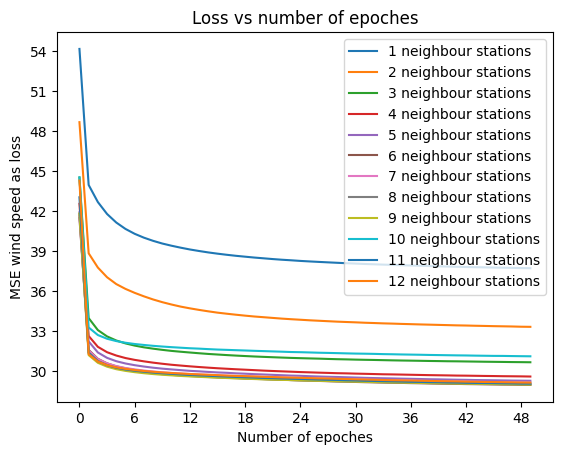

In [35]:
i = 1
fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

for exp in nn_histories:
    nn_losses = []
    for fold in exp:
        nn_losses.append(fold['loss'])
    plt.plot(np.mean(nn_losses, axis=0), label=f"{i} neighbour stations")
    i = i+1


plt.legend(loc="upper right")
#plt.ylim(5)
plt.xlabel('Number of epoches')
plt.ylabel('MSE wind speed as loss')
plt.title('Loss vs number of epoches')

In [36]:
opt_x = pd.read_csv('Data/exp/6x.csv', index_col=0)
opt_y = pd.read_csv('Data/exp/6y.csv', index_col=0)

FCM traning RMSE: 6.20895860199935
FCM traning RMSE: 6.039809208485269
FCM traning RMSE: 5.990530359381543
FCM traning RMSE: 5.967738832399078
FCM traning RMSE: 5.868589489466896
FCM traning RMSE: 5.829166988593276
FCM traning RMSE: 5.832471466494714
FCM traning RMSE: 5.850426051106057
FCM traning RMSE: 5.76274445346001
FCM traning RMSE: 5.751704677895655
FCM traning RMSE: 5.7817622727810445
FCM traning RMSE: 5.729596742867079
FCM traning RMSE: 5.722377952351467


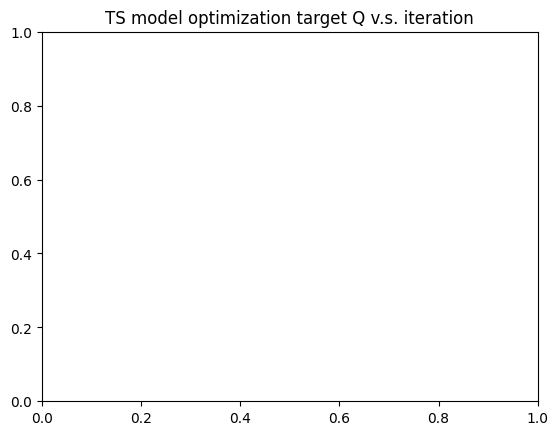

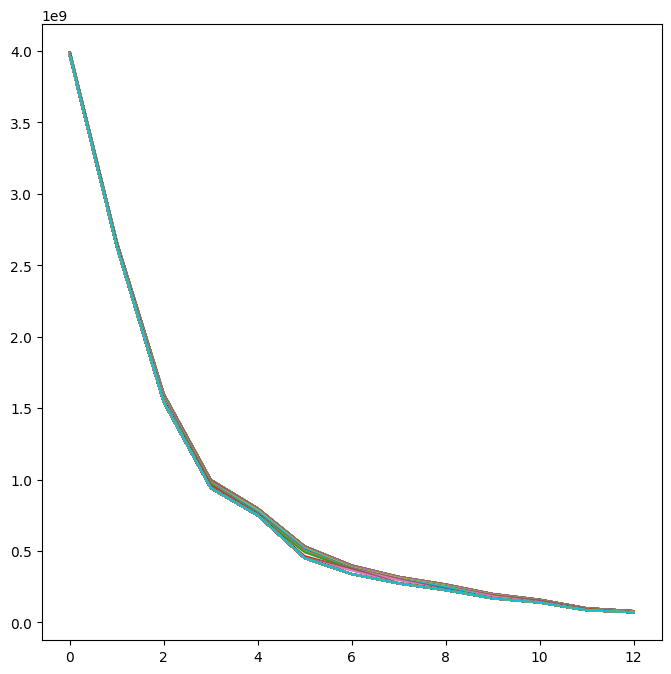

In [37]:
# Plot Q vs # of Nc
# Fcm hyperparameters
FCM_Ncs = [2,3,5,8,10,15,20,25,30,40,50,80,100]
FCM_m = 2
#tol = 1e-5
max_iter = 200
qs = []

for FCM_Nc in FCM_Ncs:   
    N = opt_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    temp_qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, opt_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(opt_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        temp_qs.append(q)

        # 检查是否收敛
#         if np.linalg.norm(U - U_old) < tol:
#             break
    # 模型训练 find if this can be optimized
    z = np.hstack((np.ones((N, 1)), opt_x))
    H = np.zeros((N, FCM_Nc * (opt_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (opt_x.shape[1] + 1, 1)).T
        H[:, (j * (opt_x.shape[1] + 1)):((j + 1) * (opt_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(opt_y)

        
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(opt_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(opt_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    qs.append(temp_qs)
    
plt.title('TS model optimization target Q v.s. iteration')
plt.figure(figsize=(8,8))
plt.plot(qs)

Text(0.5, 1.0, 'TS model optimization target Q v.s. iteration for differenct number of rules')

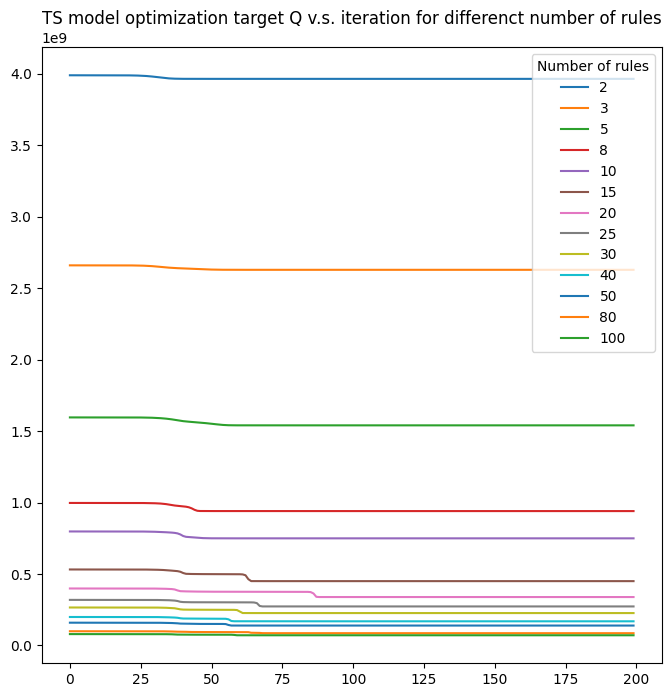

In [45]:
plt.figure(figsize=(8,8))

for exp in qs:
    plt.plot(exp)

plt.legend(FCM_Ncs, title="Number of rules")
plt.title('TS model optimization target Q v.s. iteration for differenct number of rules')